# External Validation Analysis
* A notebook to analyze the performance of OpenSOL on external validation sets

In [1]:
import os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem.Descriptors import MolWt, MolLogP, NumHDonors, NumHAcceptors, TPSA
from rdkit.Chem.rdMolDescriptors import CalcNumRotatableBonds, CalcFractionCSP3, CalcNumAromaticRings

In [2]:
dirs_pred = '../Test/prediction'
dirs_stat = '../Test/stat'
dirs_graph = '../Test/graph'
smiles = 'SMILES'
molecule = 'molecule'

MP_expr = 'MP_expr'
logS_expr = 'logS_expr'

drug_likeness = 'drug_likeness'
rdkit_ClogP = 'rdkit_ClogP'
SFI = 'SFI'

random_forest_MP = 'random_forest_MP'
xgboost_MP = 'xgboost_MP'
dnn_MP = 'dnn_MP'

knn_max = 'knn_max'
knn_mean = 'knn_mean'

random_forest_logS = 'random_forest_logS'
xgboost_logS = 'xgboost_logS'
dnn_logS = 'dnn_logS'
esol_logS = 'esol_logS'

## 1. List six external validation sets

In [3]:
csv_list = [f for f in os.listdir(dirs_pred) if f.endswith('.csv')]
csv_list

['SI_dataset_five_sol.csv',
 'SI_dataset_four_sol.csv',
 'SI_dataset_one_sol.csv',
 'SI_dataset_six_sol.csv',
 'SI_dataset_three_sol.csv',
 'SI_dataset_two_sol.csv']

## 2. Performance evaluation on external validation sets

In [4]:
def reg_plot(df, expr, pred, xlabel, ylabel, jpg_dir, legend, drug_like=True):
    # regression plotting of expr vs pred for both melting point and logS
    %matplotlib inline
    font = {'family': 'DejaVu Sans', 'weight': 'normal', 'size': 13}
    matplotlib.rc('font', **font)
    fig = plt.figure(figsize=(9.0, 6.0), facecolor=(1, 1, 1))
    fig, ax1 = plt.subplots()
    
    X1 = df[expr].to_numpy()
    
    if type(pred) == list:
        Y1 = df[pred].mean(axis=1).to_numpy()
    else:
        Y1 = df[pred].to_numpy()
        
    colors = ['b', 'r', 'm', 'y']
    nas = np.logical_or(np.isnan(X1), np.isnan(Y1))
    X1 = X1[~nas]
    Y1 = Y1[~nas]
    coef1 = np.polyfit(X1, Y1, 1)
    poly1d_fn = np.poly1d(coef1)
    #R2_full = round(pearsonr(Y1, poly1d_fn(X1))[0] ** 2, 2)
    R2_full = round(r2_score(Y1, poly1d_fn(X1)), 2)
    plt.scatter(X1, Y1, c= colors[0], alpha=.8, label='{} ($r^2$={})'.format(legend, R2_full))
    plt.plot(X1, poly1d_fn(X1), color=colors[0])
    
    if drug_like == True:
        X2 = df.loc[df.drug_likeness == True, expr].to_numpy()
        
        if type(pred) == list:
            Y2 = df.loc[df.drug_likeness == True, pred].mean(axis=1).to_numpy()
        else:
            Y2 = df.loc[df.drug_likeness == True, pred].to_numpy()
            
        nas = np.logical_or(np.isnan(X2), np.isnan(Y2))
        X2 = X2[~nas]
        Y2 = Y2[~nas]
    
        coef2 = np.polyfit(X2, Y2, 1)
        poly1d_fn = np.poly1d(coef2)
        #R2_drug_like = round(pearsonr(Y2, poly1d_fn(X2))[0] ** 2, 2)
        R2_drug_like = round(r2_score(Y2, poly1d_fn(X2)), 2)
        
        plt.scatter(X2, Y2, c=colors[1], marker='v', alpha=.5, label='Drug-like ($r^2$={})'.format(R2_drug_like))
        plt.plot(X2, poly1d_fn(X2), color=colors[1])
    #plots the histogram

    plt.xticks(rotation=60)
    #plt.yticks(rotation=-15)
    ax1.set_ylabel(ylabel)
    ax1.set_xlabel(xlabel)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.grid(which='major', linestyle=':', linewidth=1)
    if jpg_dir:
        fig.savefig(jpg_dir, dpi=300)
    plt.show()

In [5]:
def error_plot(df, expr, pred, xlabel, ylabel, legend, mode, jpg_dir):
    # error/residues plotting
    %matplotlib inline
    font = {'family': 'DejaVu Sans', 'weight': 'normal', 'size': 13}
    matplotlib.rc('font', **font)
    fig = plt.figure(figsize=(9.0, 6.0), facecolor=(1, 1, 1))
    fig, ax1 = plt.subplots()
    
    X1 = df[expr].to_numpy()
    
    if type(pred) == list:
        Y2 = df[pred].mean(axis=1).to_numpy()
        Y1 = X1 - Y2
    else:
        Y2 = df[pred].to_numpy()
        if pred in ['SFI', 'rdkit_ClogP']:
            Y1 = X1 + Y2
        else:
            Y1 = X1 - Y2
        
    colors = ['b', 'r', 'm', 'y']
    nas = np.logical_or(np.isnan(X1), np.isnan(Y1))
    X1 = X1[~nas]
    Y1 = Y1[~nas]
    Y2 = Y2[~nas]
    if mode == 'expr':
        coef1 = np.polyfit(X1, Y1, 1)
        poly1d_fn = np.poly1d(coef1)
        #R2_full = round(pearsonr(Y1, poly1d_fn(X1))[0] ** 2, 2)
        R2_full = round(r2_score(Y1, poly1d_fn(X1)), 2)
        plt.scatter(X1, Y1, c= colors[0], alpha=.5, label='{} ($r^2$={})'.format(legend, R2_full))
        plt.plot(X1, poly1d_fn(X1), color=colors[1])
    elif mode == 'pred':
        coef1 = np.polyfit(Y2, Y1, 1)
        poly1d_fn = np.poly1d(coef1)
        #R2_full = round(pearsonr(Y1, poly1d_fn(Y2))[0] ** 2, 2)
        R2_full = round(r2_score(Y1, poly1d_fn(Y2)), 2)
        plt.scatter(Y2, Y1, c= colors[0], alpha=.5, label='{} ($r^2$={})'.format(legend, R2_full))
        plt.plot(Y2, poly1d_fn(Y2), color=colors[1]) 

    
    plt.xticks(rotation=60)
    #plt.yticks(rotation=-15)
    ax1.set_ylabel(ylabel)
    ax1.set_xlabel(xlabel)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.grid(which='major', linestyle=':', linewidth=1)
    if jpg_dir:
        fig.savefig(jpg_dir, dpi=300)
    plt.show()

In [6]:
def _r2(x, y):
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    return pearsonr(x[~nas], y[~nas])[0] ** 2


In [7]:
def _R2(x, y):
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    return r2_score(x[~nas], y[~nas])

In [8]:
def _mae(x, y):
    # mean absolute error
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    return np.mean(abs(x[~nas] - y[~nas]))

In [9]:
def _me(x, y):
    # mean error
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    return np.mean(x[~nas] - y[~nas])

In [10]:
def _stdev(x, y):
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    return np.std(abs(x[~nas] - y[~nas]))

In [11]:
def _rmse(x, y):
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    return np.sqrt(np.mean(abs(x[~nas] - y[~nas]) ** 2))

In [12]:
def _unit_pct(x, y):
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    return sum(abs(x[~nas] - y[~nas]) <= 1) / len(x[~nas])

In [13]:
def _mae_pct(x, y):
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    mae = _mae(x, y)
    return sum(abs(x[~nas] - y[~nas]) <= mae) / len(x[~nas])

In [14]:
def stat_table(df, stat_file, MP=False):
    if MP == True:
        cols_list = ['random_forest_MP', 'xgboost_MP', 'dnn_MP']
        expr_col = 'MP_expr'
    else:
        cols_list = ['SFI', 'rdkit_ClogP', 'random_forest_logS', 'xgboost_logS', 'dnn_logS', 'esol_logS']
        expr_col = 'logS_expr'
    
    expr = df[expr_col].values
    #expr_drug_like = df.loc[df.drug_likeness == True, expr_col].values
    
    #stat_cols = ['#cpds', 'r2', 'MAE', 'RMSE', 'Unit1%', 'r2_drug_like', 'MAE_drug_like', 'RMSE_drug_like', 'Unit1%_druglike']
    stat_cols = ['#cpds', 'r2', 'R2', 'MAE', 'ME','STDEV', 'RMSE', 'Unit1%', 'mae%']
    df_stat = pd.DataFrame(0.0, index=cols_list, columns=stat_cols)
    
    for col in cols_list:
        if col in ['SFI', 'rdkit_ClogP']:
            pred = -df[col].values
            #pred_drug_like = -df.loc[df.drug_likeness == True, col].values
        else:
            pred = df[col].values
            #pred_drug_like = df.loc[df.drug_likeness == True, col].values
        df_stat.loc[col, ['#cpds', 'r2', 'R2','MAE', 'ME','STDEV', 'RMSE', 'Unit1%', 'mae%']] = [len(pred), _r2(expr, pred), _R2(expr, pred), _mae(expr, pred), _me(expr, pred), _stdev(expr, pred), _rmse(expr, pred), _unit_pct(expr, pred), _mae_pct(expr, pred)]
        #df_stat.loc[col, ['r2_drug_like', 'MAE_drug_like', 'RMSE_drug_like', 'Unit1%_druglike']] = [_R2(expr_drug_like, pred_drug_like), _mae(expr_drug_like, pred_drug_like), _rmse(expr_drug_like, pred_drug_like), _unit_pct(expr_drug_like, pred_drug_like)]
    
    df_stat.round(2).to_csv(stat_file, index=True)

<Figure size 648x432 with 0 Axes>

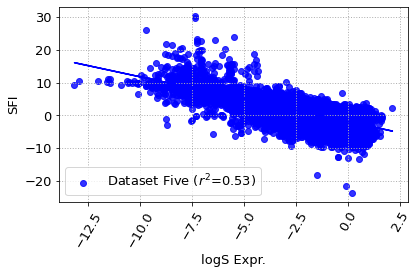

<Figure size 648x432 with 0 Axes>

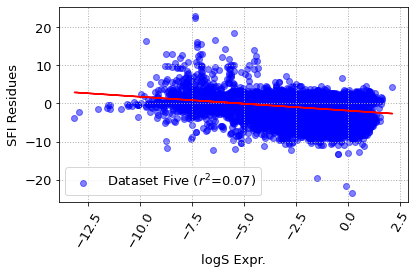

<Figure size 648x432 with 0 Axes>

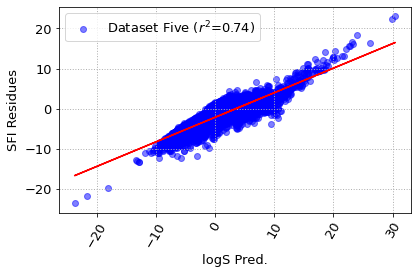

<Figure size 648x432 with 0 Axes>

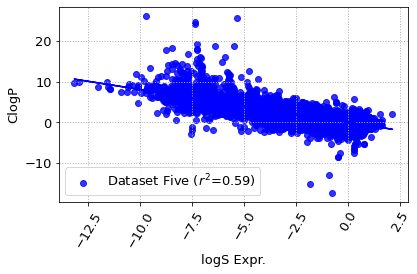

<Figure size 648x432 with 0 Axes>

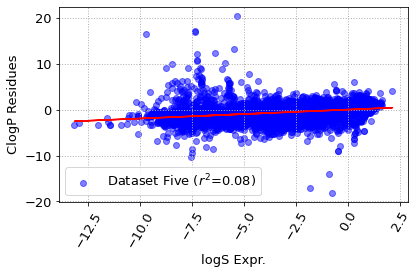

<Figure size 648x432 with 0 Axes>

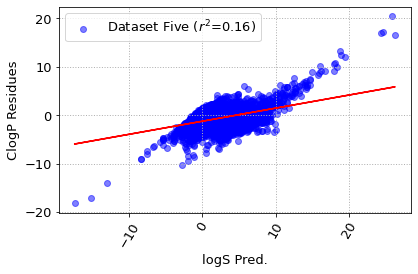

<Figure size 648x432 with 0 Axes>

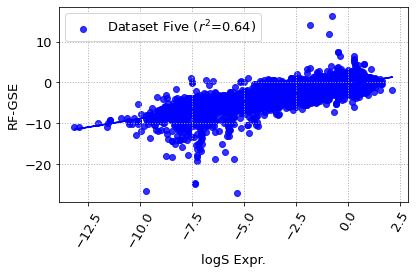

<Figure size 648x432 with 0 Axes>

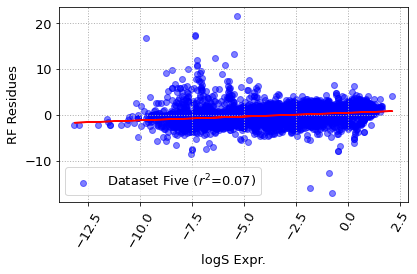

<Figure size 648x432 with 0 Axes>

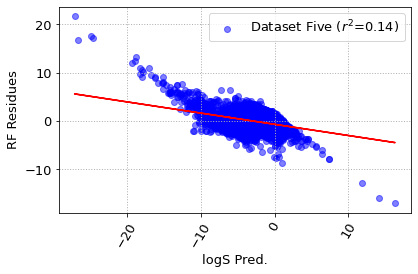

<Figure size 648x432 with 0 Axes>

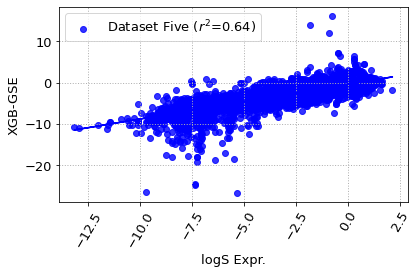

<Figure size 648x432 with 0 Axes>

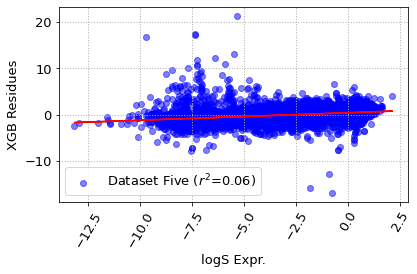

<Figure size 648x432 with 0 Axes>

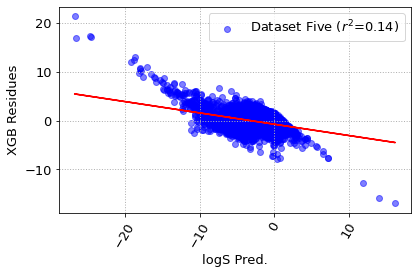

<Figure size 648x432 with 0 Axes>

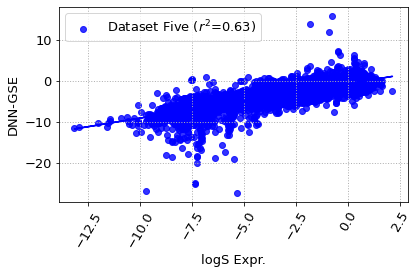

<Figure size 648x432 with 0 Axes>

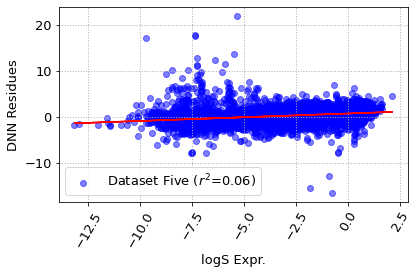

<Figure size 648x432 with 0 Axes>

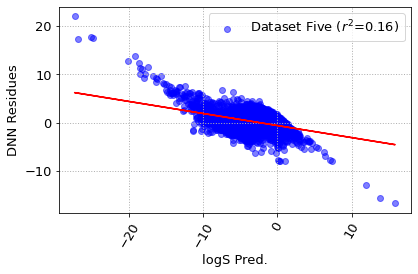

<Figure size 648x432 with 0 Axes>

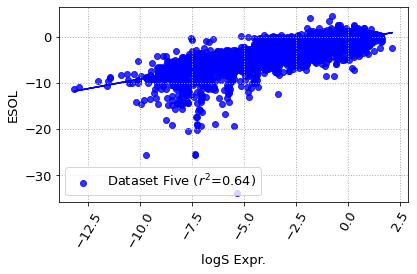

<Figure size 648x432 with 0 Axes>

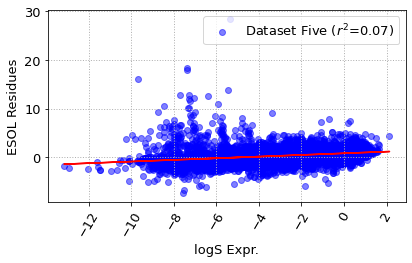

<Figure size 648x432 with 0 Axes>

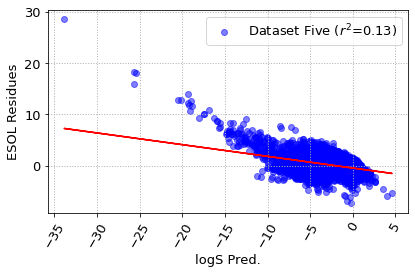

<Figure size 648x432 with 0 Axes>

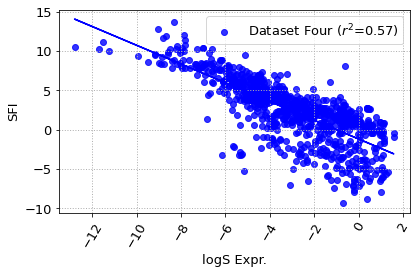

<Figure size 648x432 with 0 Axes>

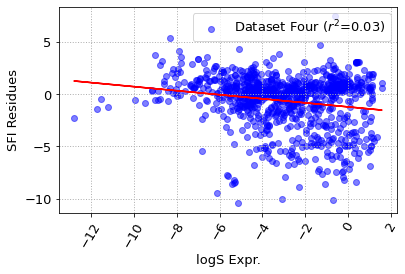

<Figure size 648x432 with 0 Axes>

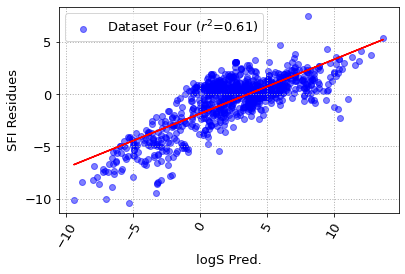

<Figure size 648x432 with 0 Axes>

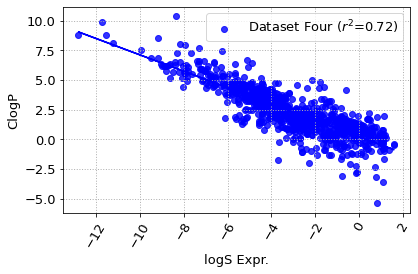

<Figure size 648x432 with 0 Axes>

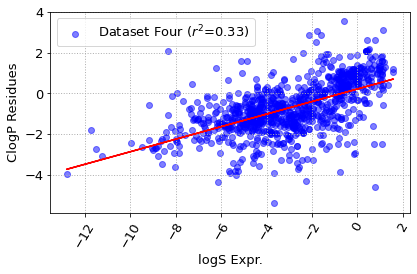

<Figure size 648x432 with 0 Axes>

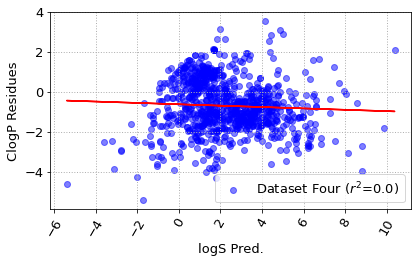

<Figure size 648x432 with 0 Axes>

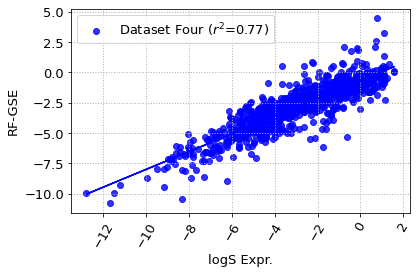

<Figure size 648x432 with 0 Axes>

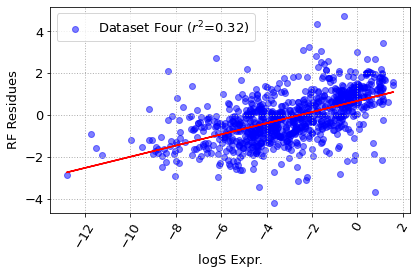

<Figure size 648x432 with 0 Axes>

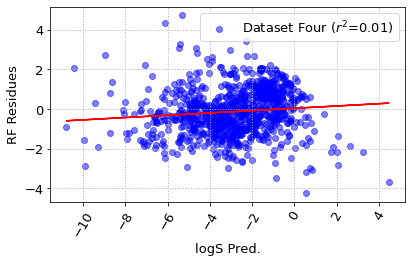

<Figure size 648x432 with 0 Axes>

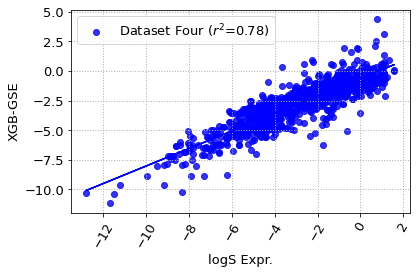

<Figure size 648x432 with 0 Axes>

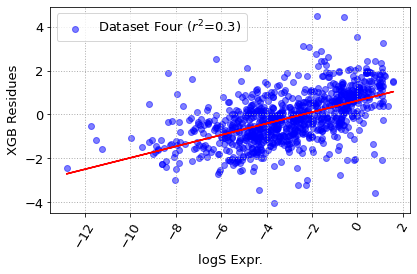

<Figure size 648x432 with 0 Axes>

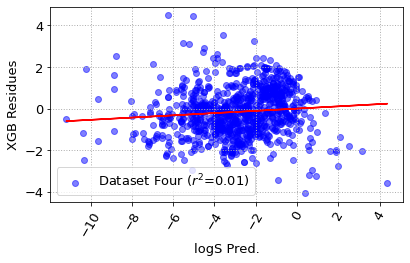

<Figure size 648x432 with 0 Axes>

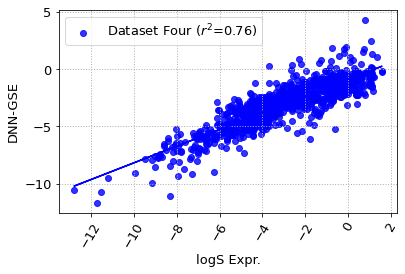

<Figure size 648x432 with 0 Axes>

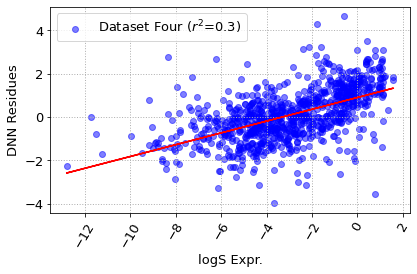

<Figure size 648x432 with 0 Axes>

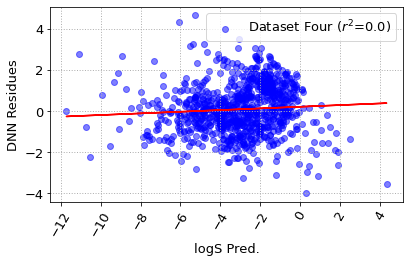

<Figure size 648x432 with 0 Axes>

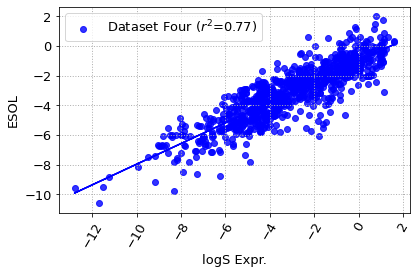

<Figure size 648x432 with 0 Axes>

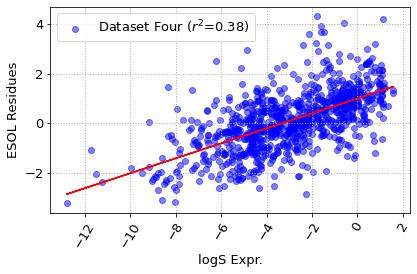

<Figure size 648x432 with 0 Axes>

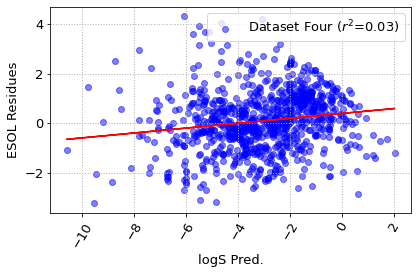

<Figure size 648x432 with 0 Axes>

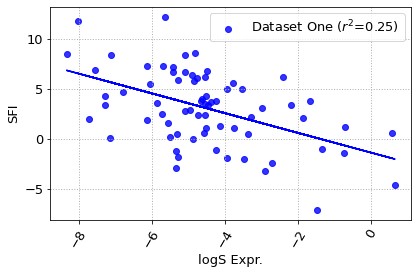

<Figure size 648x432 with 0 Axes>

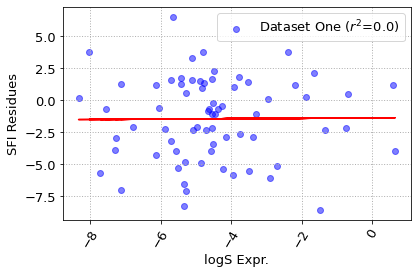

<Figure size 648x432 with 0 Axes>

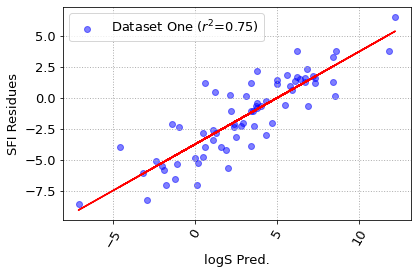

<Figure size 648x432 with 0 Axes>

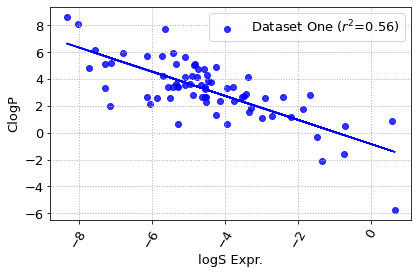

<Figure size 648x432 with 0 Axes>

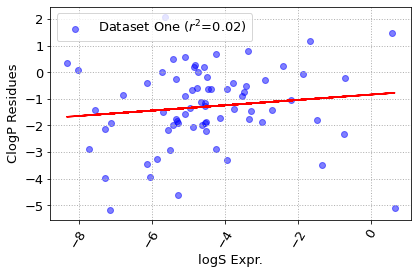

<Figure size 648x432 with 0 Axes>

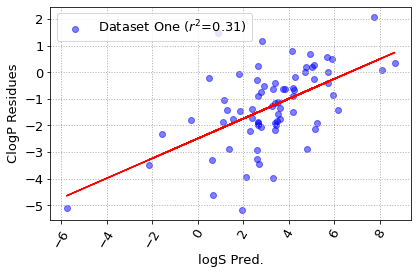

<Figure size 648x432 with 0 Axes>

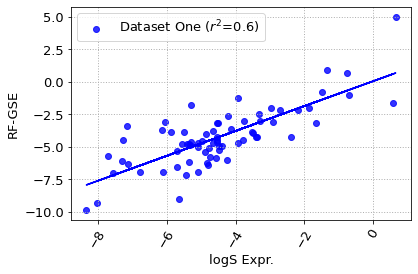

<Figure size 648x432 with 0 Axes>

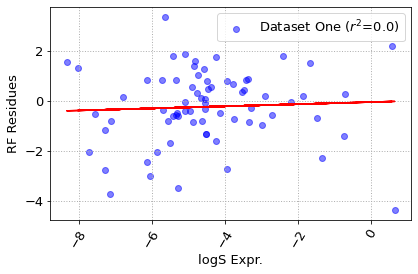

<Figure size 648x432 with 0 Axes>

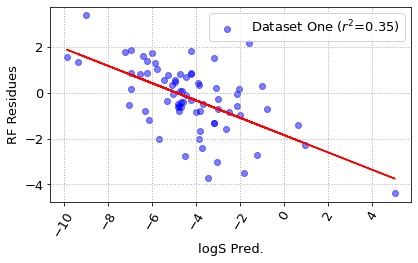

<Figure size 648x432 with 0 Axes>

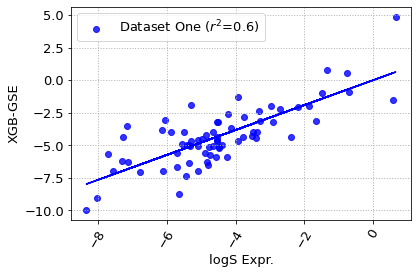

<Figure size 648x432 with 0 Axes>

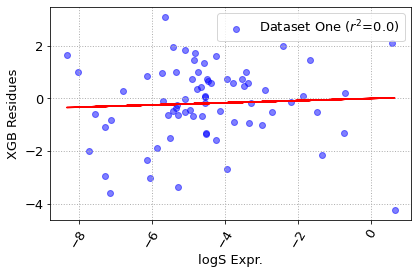

<Figure size 648x432 with 0 Axes>

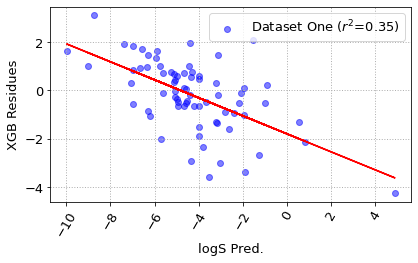

<Figure size 648x432 with 0 Axes>

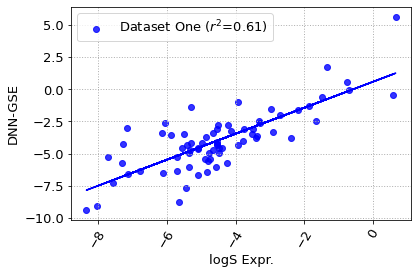

<Figure size 648x432 with 0 Axes>

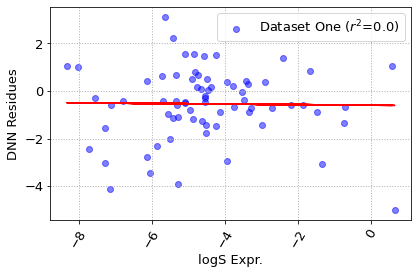

<Figure size 648x432 with 0 Axes>

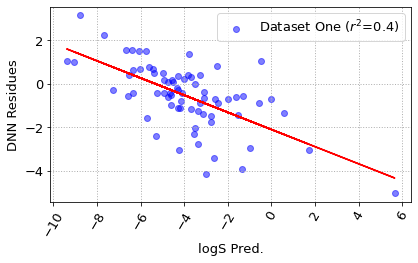

<Figure size 648x432 with 0 Axes>

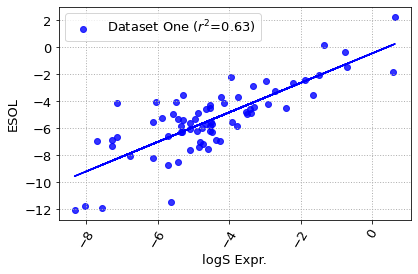

<Figure size 648x432 with 0 Axes>

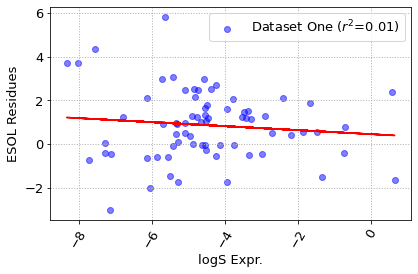

<Figure size 648x432 with 0 Axes>

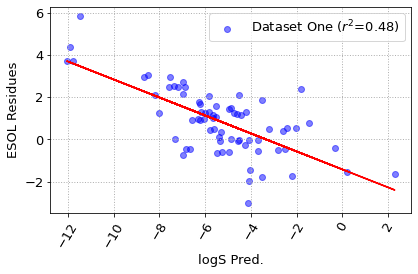

<Figure size 648x432 with 0 Axes>

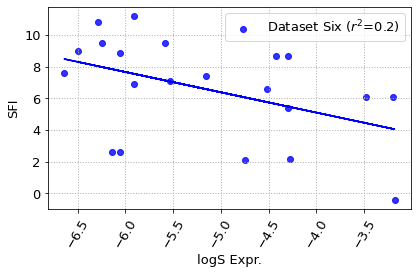

<Figure size 648x432 with 0 Axes>

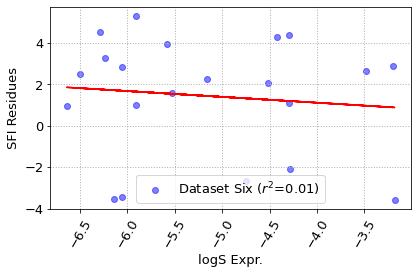

<Figure size 648x432 with 0 Axes>

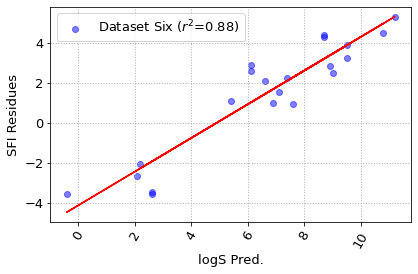

<Figure size 648x432 with 0 Axes>

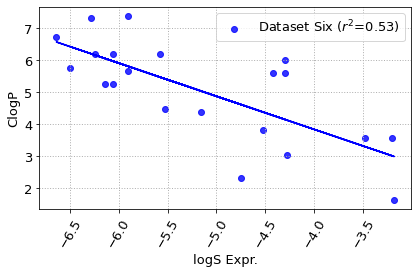

<Figure size 648x432 with 0 Axes>

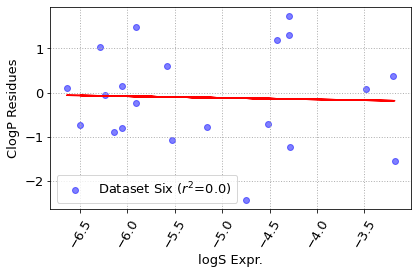

<Figure size 648x432 with 0 Axes>

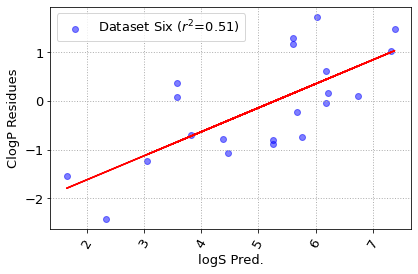

<Figure size 648x432 with 0 Axes>

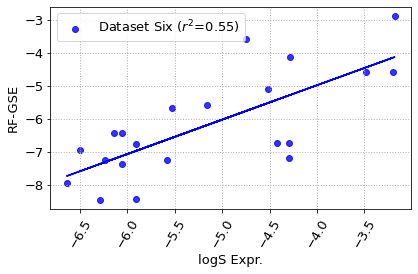

<Figure size 648x432 with 0 Axes>

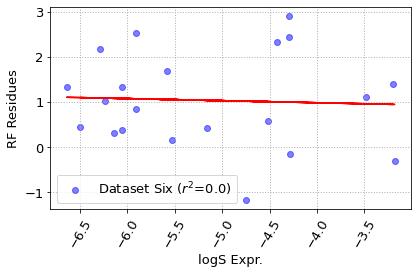

<Figure size 648x432 with 0 Axes>

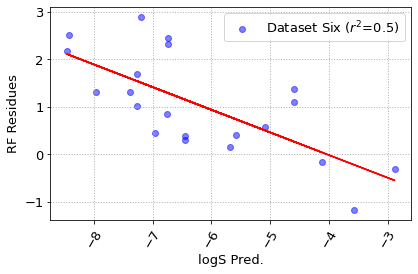

<Figure size 648x432 with 0 Axes>

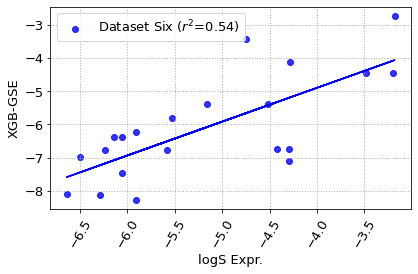

<Figure size 648x432 with 0 Axes>

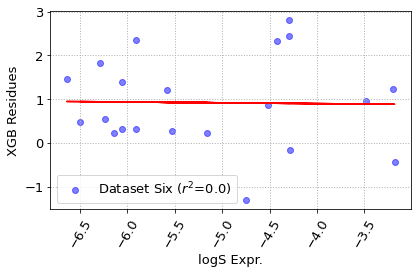

<Figure size 648x432 with 0 Axes>

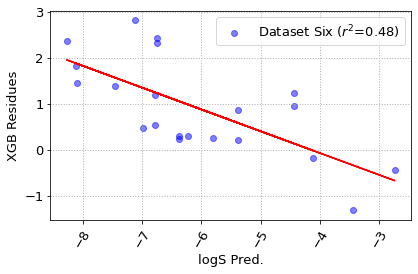

<Figure size 648x432 with 0 Axes>

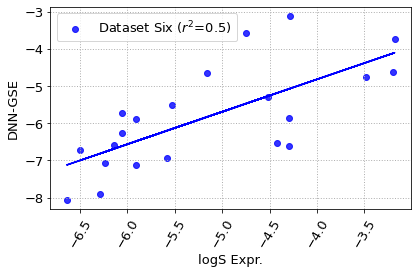

<Figure size 648x432 with 0 Axes>

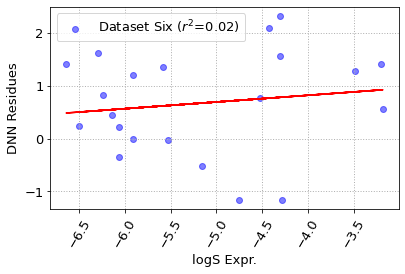

<Figure size 648x432 with 0 Axes>

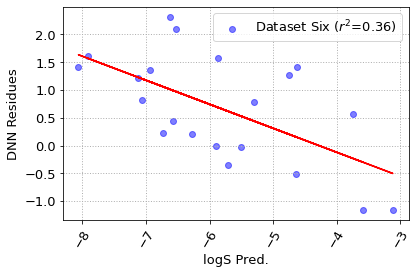

<Figure size 648x432 with 0 Axes>

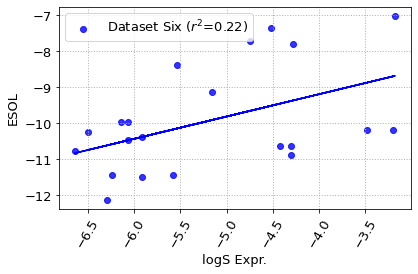

<Figure size 648x432 with 0 Axes>

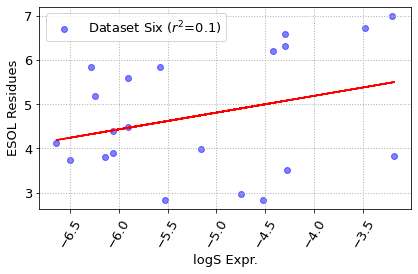

<Figure size 648x432 with 0 Axes>

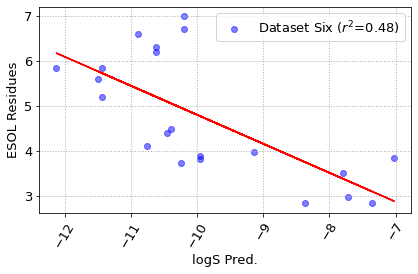

<Figure size 648x432 with 0 Axes>

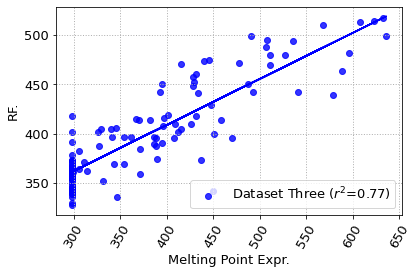

<Figure size 648x432 with 0 Axes>

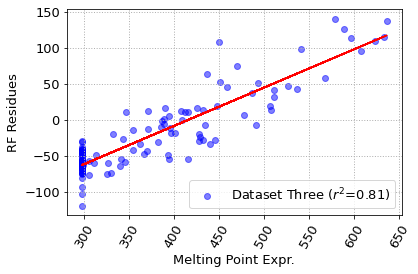

<Figure size 648x432 with 0 Axes>

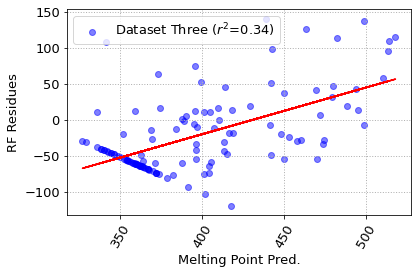

<Figure size 648x432 with 0 Axes>

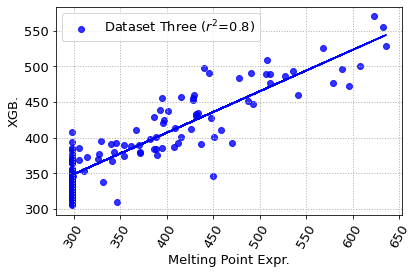

<Figure size 648x432 with 0 Axes>

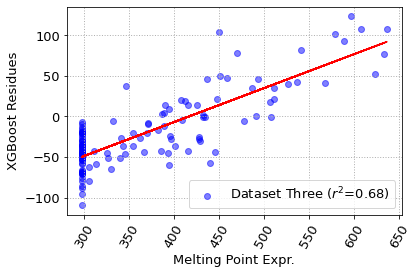

<Figure size 648x432 with 0 Axes>

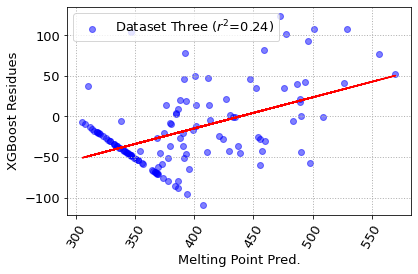

<Figure size 648x432 with 0 Axes>

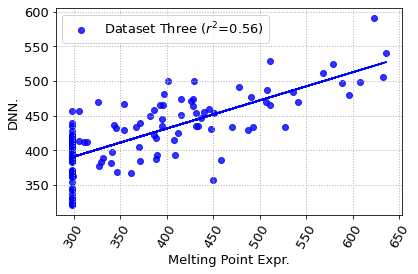

<Figure size 648x432 with 0 Axes>

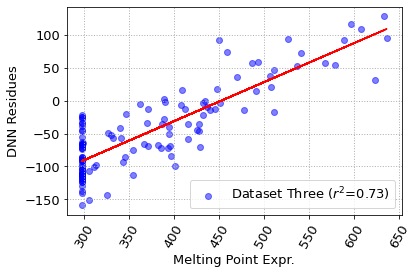

<Figure size 648x432 with 0 Axes>

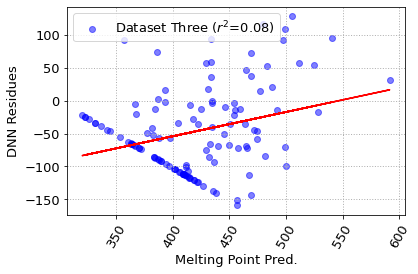

<Figure size 648x432 with 0 Axes>

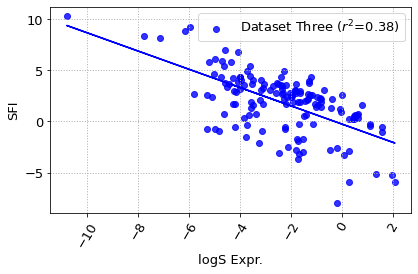

<Figure size 648x432 with 0 Axes>

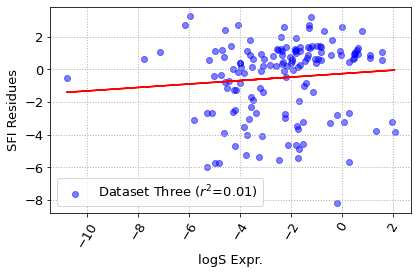

<Figure size 648x432 with 0 Axes>

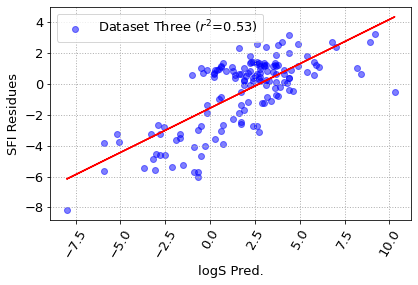

<Figure size 648x432 with 0 Axes>

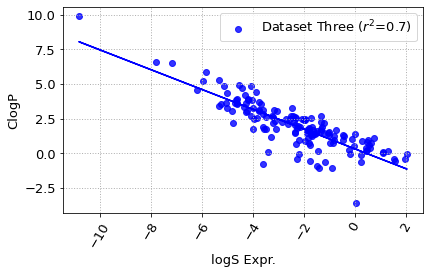

<Figure size 648x432 with 0 Axes>

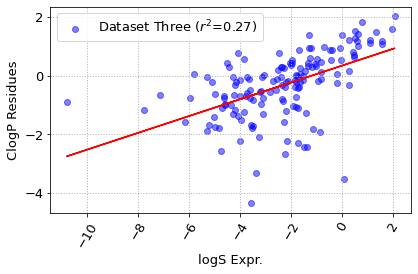

<Figure size 648x432 with 0 Axes>

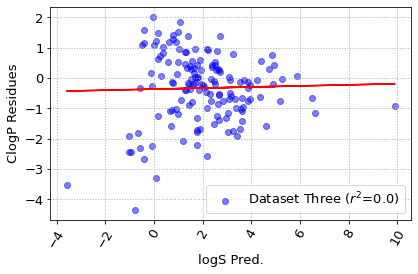

<Figure size 648x432 with 0 Axes>

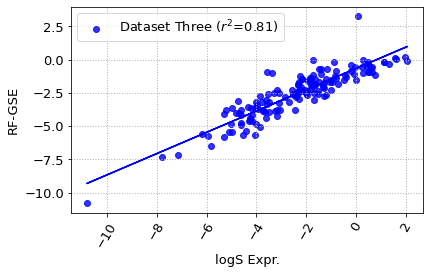

<Figure size 648x432 with 0 Axes>

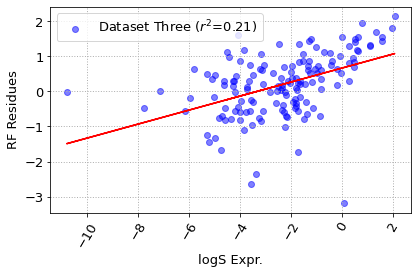

<Figure size 648x432 with 0 Axes>

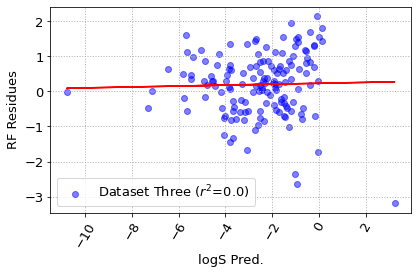

<Figure size 648x432 with 0 Axes>

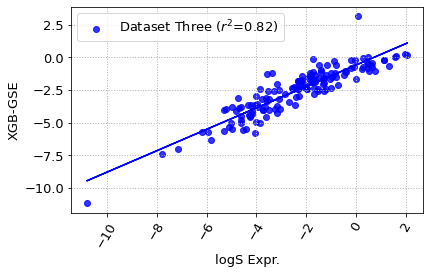

<Figure size 648x432 with 0 Axes>

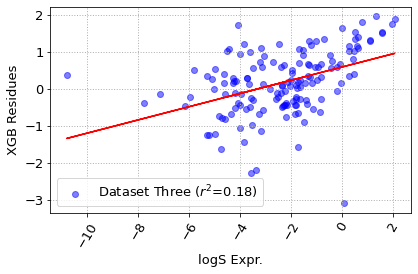

<Figure size 648x432 with 0 Axes>

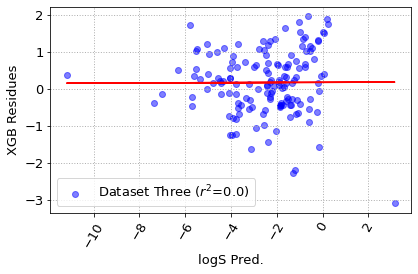

<Figure size 648x432 with 0 Axes>

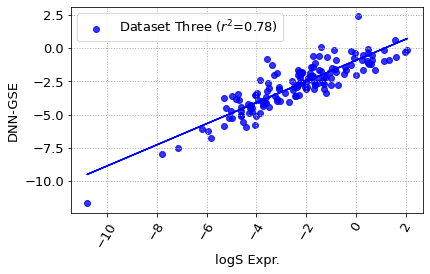

<Figure size 648x432 with 0 Axes>

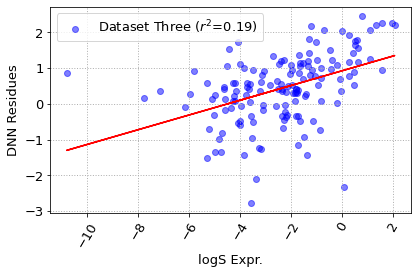

<Figure size 648x432 with 0 Axes>

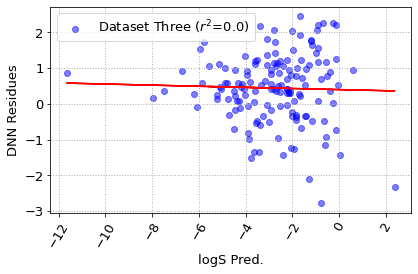

<Figure size 648x432 with 0 Axes>

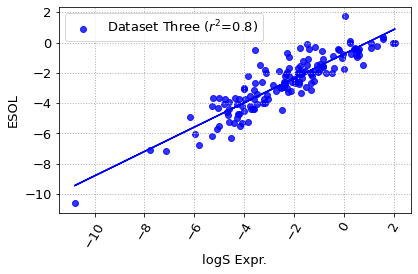

<Figure size 648x432 with 0 Axes>

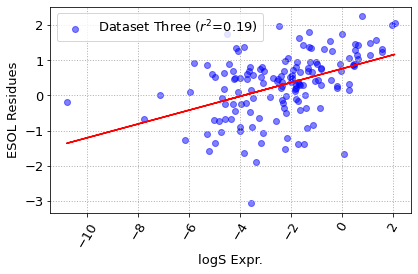

<Figure size 648x432 with 0 Axes>

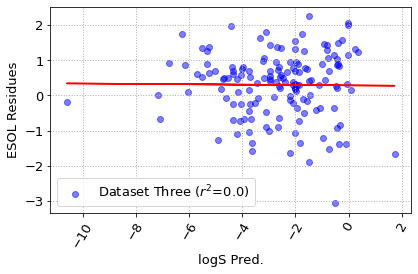

<Figure size 648x432 with 0 Axes>

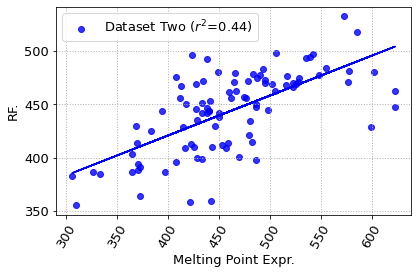

<Figure size 648x432 with 0 Axes>

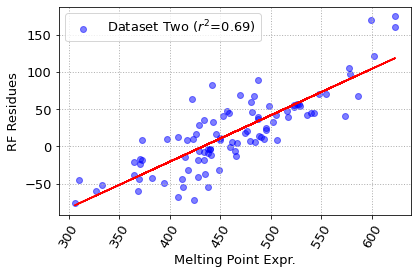

<Figure size 648x432 with 0 Axes>

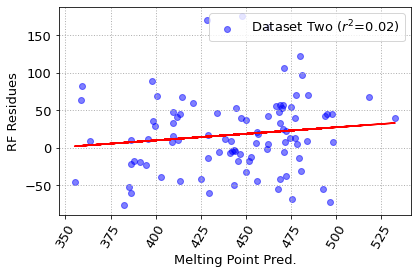

<Figure size 648x432 with 0 Axes>

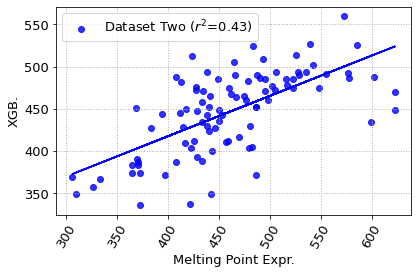

<Figure size 648x432 with 0 Axes>

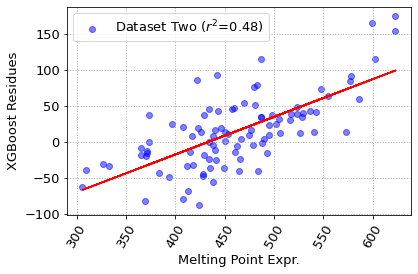

<Figure size 648x432 with 0 Axes>

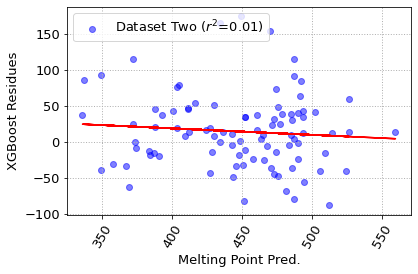

<Figure size 648x432 with 0 Axes>

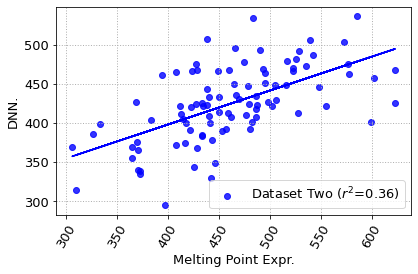

<Figure size 648x432 with 0 Axes>

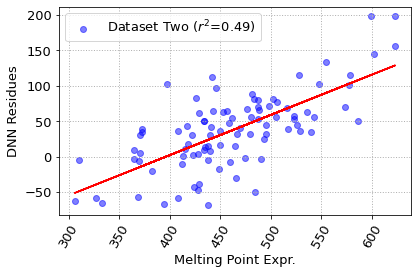

<Figure size 648x432 with 0 Axes>

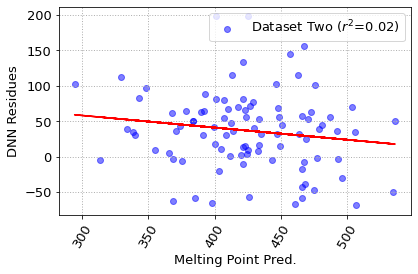

<Figure size 648x432 with 0 Axes>

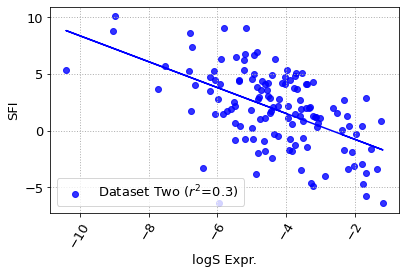

<Figure size 648x432 with 0 Axes>

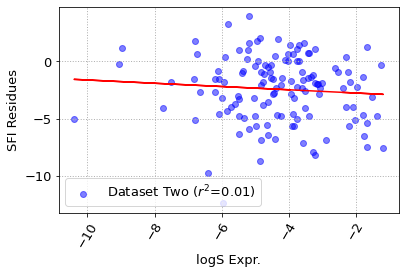

<Figure size 648x432 with 0 Axes>

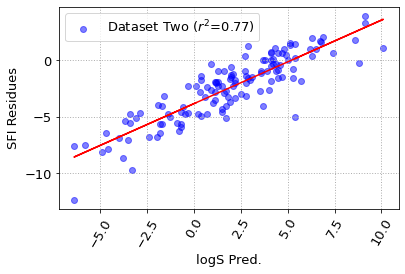

<Figure size 648x432 with 0 Axes>

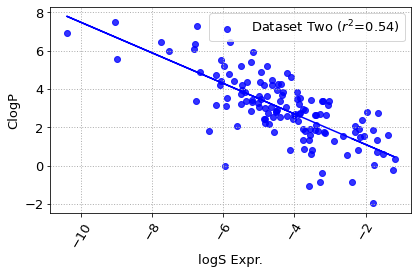

<Figure size 648x432 with 0 Axes>

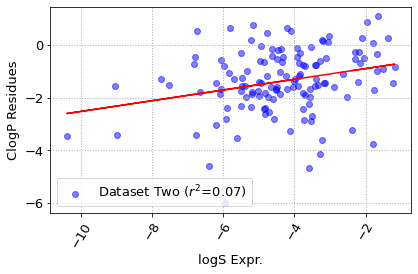

<Figure size 648x432 with 0 Axes>

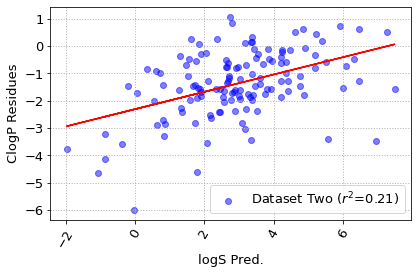

<Figure size 648x432 with 0 Axes>

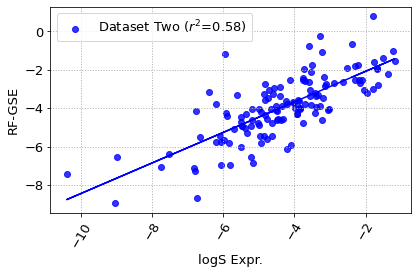

<Figure size 648x432 with 0 Axes>

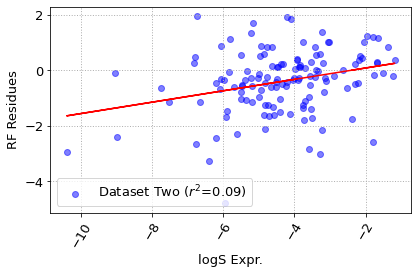

<Figure size 648x432 with 0 Axes>

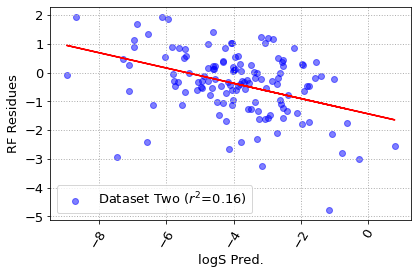

<Figure size 648x432 with 0 Axes>

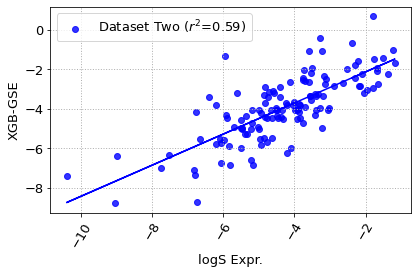

<Figure size 648x432 with 0 Axes>

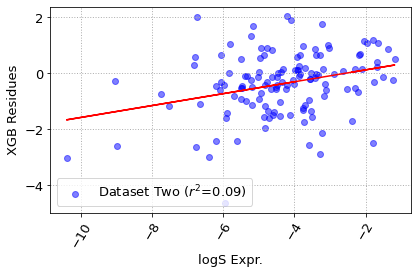

<Figure size 648x432 with 0 Axes>

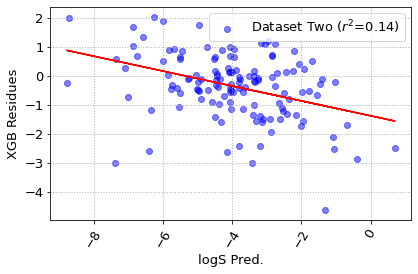

<Figure size 648x432 with 0 Axes>

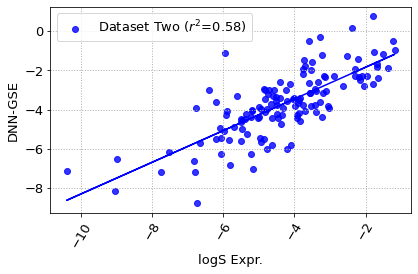

<Figure size 648x432 with 0 Axes>

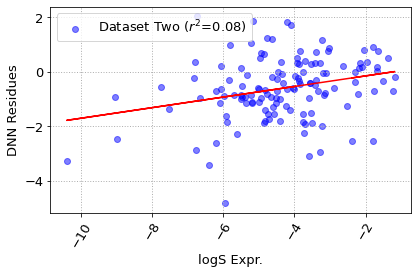

<Figure size 648x432 with 0 Axes>

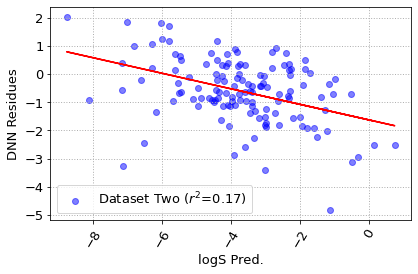

<Figure size 648x432 with 0 Axes>

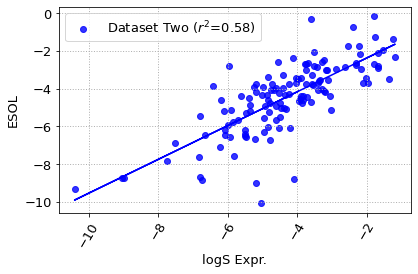

<Figure size 648x432 with 0 Axes>

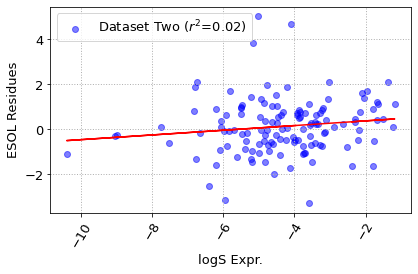

<Figure size 648x432 with 0 Axes>

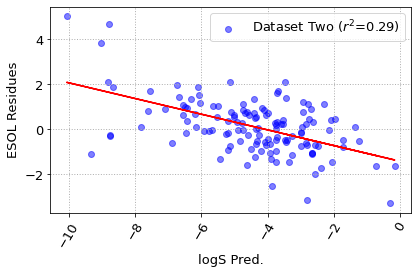

In [15]:
for csv in csv_list:
    poor_solubility = -4.0
    csv_file = '{}/{}'.format(dirs_pred, csv)
    df = pd.read_csv(csv_file, index_col=None)
    
    
    csv_base = csv.split('_pred')[0]
    if 'one' in csv_base:
        legend = 'Dataset One'
    elif 'two' in csv_base:
        legend = 'Dataset Two'
    elif 'three' in csv_base:
        legend = 'Dataset Three'
    elif 'four' in csv_base:
        legend = 'Dataset Four'
    elif 'five' in csv_base:
        legend = 'Dataset Five'
    else:
        legend = 'Dataset Six'
        
    if 'two' in csv or 'three' in csv:
        # remove compounds in the training set
        df2 = df.loc[df.knn_max < 1]
        stat_file = '{}/{}'.format(dirs_stat, csv_base + '_stat_MP.csv')
        stat_table(df2, stat_file, MP=True)
        
        stat_file = '{}/{}'.format(dirs_stat, csv_base + '_stat_MP_poor.csv')
        df_poor = df2.loc[df2.logS_expr < poor_solubility]
        stat_table(df_poor, stat_file, MP=True)

        df_good = df2.loc[df2.logS_expr >= poor_solubility]
        stat_file = '{}/{}'.format(dirs_stat, csv_base + '_stat_MP_good.csv')
        stat_table(df_good, stat_file, MP=True)
        
        cols_list = ['random_forest_MP', 'xgboost_MP', 'dnn_MP']
        expr_col = 'MP_expr'
        xlabel = 'Melting Point Expr.'
        ylabel_list = ['RF.', 'XGB.', 'DNN.']
        ylabel_error_list = ['RF Residues', 'XGBoost Residues', 'DNN Residues']
        for i, col in enumerate(cols_list):
            jpg_dir_reg_plot = '{}/{}_{}_{}_reg_plot_MP.jpg'.format(dirs_graph, csv_base, expr_col, col)
            #reg_plot(df, expr_col, col, xlabel, ylabel_list[i], jpg_dir_reg_plot, legend, drug_like=True)
            reg_plot(df2, expr_col, col, xlabel, ylabel_list[i], jpg_dir_reg_plot, legend, drug_like=False)
            mode = 'expr'
            jpg_dir_error_plot = '{}/{}_{}_{}_error_plot_MP_expr.jpg'.format(dirs_graph, csv_base, expr_col, col)
            error_plot(df2, expr_col, col, xlabel, ylabel_error_list[i], legend, mode, jpg_dir_error_plot)
            mode = 'pred'
            jpg_dir_error_plot = '{}/{}_{}_{}_error_plot_MP_pred.jpg'.format(dirs_graph, csv_base, expr_col, col)
            error_plot(df2, expr_col, col, 'Melting Point Pred.', ylabel_error_list[i], legend, mode, jpg_dir_error_plot)
        

    stat_file = '{}/{}'.format(dirs_stat, csv_base + '_stat_logS.csv')
    stat_table(df, stat_file, MP=False)
    
    
    stat_file = '{}/{}'.format(dirs_stat, csv_base + '_stat_logS_poor.csv')
    df_poor = df.loc[df.logS_expr < poor_solubility]
    stat_table(df_poor, stat_file, MP=False)
    
    df_good = df.loc[df.logS_expr >= poor_solubility]
    stat_file = '{}/{}'.format(dirs_stat, csv_base + '_stat_logS_good.csv')
    stat_table(df_good, stat_file, MP=False)
    
    cols_list = ['SFI', 'rdkit_ClogP', 'random_forest_logS', 'xgboost_logS', 'dnn_logS', 'esol_logS']
    expr_col = 'logS_expr'
    xlabel = 'logS Expr.'
    ylabel_list = ['SFI', 'ClogP', 'RF-GSE', 'XGB-GSE', 'DNN-GSE', 'ESOL']
    ylabel_error_list = ['SFI Residues', 'ClogP Residues', 'RF Residues', 'XGB Residues', 'DNN Residues', 'ESOL Residues']
    for i, col in enumerate(cols_list):
        jpg_dir_reg_plot = '{}/{}_{}_{}_reg_plot_logS.jpg'.format(dirs_graph, csv_base, expr_col, col)
        if 'six' in csv_base:
            reg_plot(df, expr_col, col, xlabel, ylabel_list[i], jpg_dir_reg_plot, legend, drug_like=False)
        else:
            #reg_plot(df, expr_col, col, xlabel, ylabel_list[i], jpg_dir_reg_plot, legend, drug_like=True)
            reg_plot(df, expr_col, col, xlabel, ylabel_list[i], jpg_dir_reg_plot, legend, drug_like=False)
        jpg_dir_error_plot = '{}/{}_{}_{}_error_plot_logS_expr.jpg'.format(dirs_graph, csv_base, expr_col, col)
        mode = 'expr'
        error_plot(df, expr_col, col, xlabel, ylabel_error_list[i], legend, mode, jpg_dir_error_plot)
        mode = 'pred'
        jpg_dir_error_plot = '{}/{}_{}_{}_error_plot_logS_pred.jpg'.format(dirs_graph, csv_base, expr_col, col)
        error_plot(df, expr_col, col, 'logS Pred.', ylabel_error_list[i], legend, mode, jpg_dir_error_plot)

## 3. Melting point model validation
* SI_dataset_two and SI_dataset_three

In [46]:
def MP_plot(df, stat):
    %matplotlib inline
    plt.figure(figsize=(12, 9))
    plt.rcParams.update({'font.size': 18}) # must set in top
    ax = df.plot.bar(figsize=(9, 6))
    if stat == 'MAE':
        ax.set_ylim(0, 100)
    else:
        ax.set_ylim(-50, 50)
    ax.set_xlabel("Method", fontdict={'fontsize':22})
    ax.set_ylabel(stat, fontdict={'fontsize':22})
    plt.legend(ncol=1, loc="upper right")
    plt.xticks(rotation=0)
    plt.grid(which='major', linestyle=':', linewidth=1)
    plt.savefig('../Test/graph/MP_validation_dataset_2_3_{}.jpg'.format(stat), dpi=300)

In [47]:
mp_csv_list = ['SI_dataset_two_sol.csv', 'SI_dataset_three_sol.csv']
idx_list = ['DNN', 'XGB', 'RF']
col_list = ['Dataset 2', 'Dataset 3']
mdl_MP_list = [dnn_MP, xgboost_MP, random_forest_MP]
stats = ['MAE', 'ME']

In [48]:
df_stat_MAE = pd.DataFrame(0.0, index=mdl_MP_list, columns=col_list)
df_stat_ME = pd.DataFrame(0.0, index=mdl_MP_list, columns=col_list)
for i, csv in enumerate(mp_csv_list):
    df_tmp = pd.read_csv('{}/{}'.format(dirs_pred, mp_csv_list[i]))
    df_tmp = df_tmp.loc[df_tmp.knn_max < 1.0]

    for j, mdl_mp in enumerate(mdl_MP_list):
        df_stat_MAE.loc[mdl_MP_list[j], col_list[i]] =  _mae(df_tmp[MP_expr], df_tmp[mdl_mp])
        df_stat_ME.loc[mdl_MP_list[j], col_list[i]] =  _me(df_tmp[MP_expr], df_tmp[mdl_mp])
    

### 3.1  MAE of melting point for dataset 2 and 3

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


<Figure size 864x648 with 0 Axes>

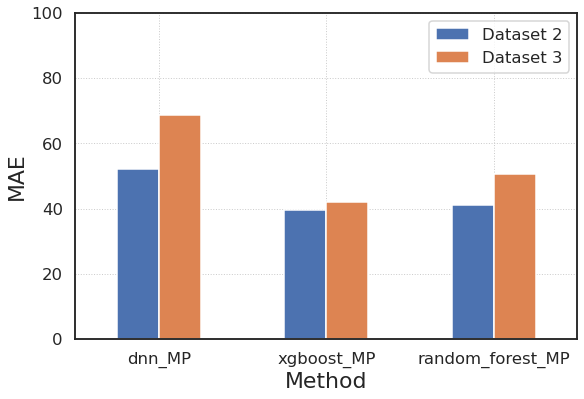

In [49]:
MP_plot(df_stat_MAE, 'MAE')

### 3.2  ME of melting point for dataset 2 and 3

<Figure size 864x648 with 0 Axes>

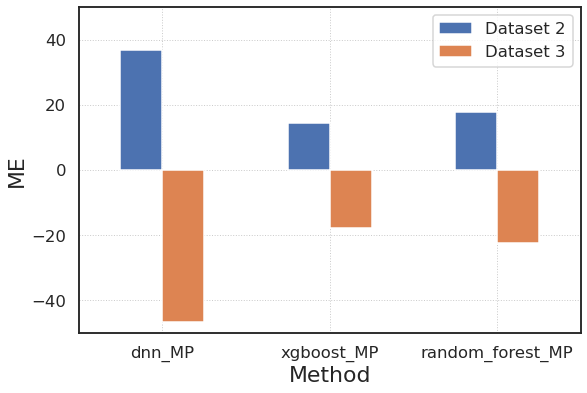

In [50]:
MP_plot(df_stat_ME, 'ME')

## 4. Similarity between the training and test sets 
* Comparison between the Random and realistic (clustering) Split

In [51]:
sim_stat = '../Test/stat/mp_trn_tst_sim_stat.csv'
jpg_dir = '../Test/graph/Clustering_vs_random_plot.jpg'

In [52]:
df = pd.read_csv(sim_stat, index_col=0)
df.drop(['Mean', 'Std'], axis=1, inplace=True)
df

0.0-0.1  0.1-0.2  0.2-0.3  0.3-0.4  0.4-0.5  0.5-0.6  0.6-0.7  \
clustering      0.0     19.0   1710.0   8130.0   4815.0     21.0      4.0   
random          0.0      0.0    366.0   2337.0   3727.0   3020.0   2041.0   

            0.7-0.8  0.8-0.9  0.9-1.0  
clustering      3.0      1.0      0.0  
random       1507.0    555.0   1149.0

In [53]:
df.loc['clustering'] = df.loc['clustering'] / df.loc['clustering'].sum()
df.loc['random'] = df.loc['random'] / df.loc['random'].sum()

<Figure size 648x432 with 0 Axes>

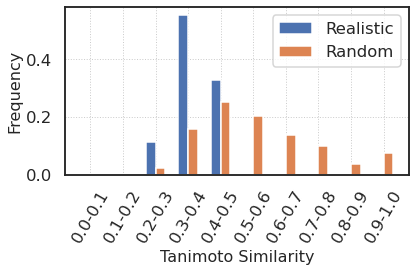

In [54]:
%matplotlib inline
font = {'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14}
matplotlib.rc('font', **font)
fig = plt.figure(figsize=(9.0, 6.0), facecolor=(1, 1, 1))
width = 0.3
fig, ax1 = plt.subplots()
ind = np.array(range(0, 10))
plt.bar(ind, df.loc['clustering'] , width, label='Realistic')
plt.bar(ind + width, df.loc['random'], width, label='Random')
plt.xticks(ind + width / 2, df.columns, rotation=60, )
plt.xlabel('Tanimoto Similarity', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.legend(loc='best')
plt.tight_layout()
plt.grid(which='major', linestyle=':', linewidth=1)
fig.savefig(jpg_dir, dpi=300)
plt.show()

## 5. Catergorical analysis of OpenSOL and SFI

In [ ]:
def cls_plot(stat_cls, col, ylabel):
    plt.figure(figsize=(12, 9))
    plt.rcParams.update({'font.size': 18}) # must set in top
    stat_tmp = stat_cls[['SFI_{}'.format(col), 'dnn_{}'.format(col), 'xgb_{}'.format(col),'RF_{}'.format(col)]].copy()
    stat_tmp.columns = ['SFI', 'DNN', 'XGB', 'RF']
    ax = stat_tmp.plot.bar(figsize=(9, 6))
    ax.set_ylim(0, 1.19)
    ax.set_xlabel("Dataset", fontdict={'fontsize':22})
    ax.set_ylabel(ylabel, fontdict={'fontsize':22})
    plt.legend(ncol=4, loc="upper right")
    plt.xticks(rotation=60)
    plt.grid(which='major', linestyle=':', linewidth=1)
    plt.savefig('../Test/graph/SFI_vs_OpenSOL_{}.jpg'.format(ylabel), dpi=300)

In [ ]:
sol_thr = -4
stat_cls = pd.DataFrame(0.0, index=range(6), columns=['cpds', 'cpds_lt_-4', 'cpds_gt_-4', 'SFI_sens', 'SFI_prec','SFI_spec', 'SFI_acc', 'RF_sens', 'RF_prec','RF_spec', 'RF_acc', 'xgb_sens', 'xgb_prec', 'xgb_spec', 'xgb_acc', 'dnn_sens', 'dnn_prec','dnn_spec', 'dnn_acc'])

In [27]:
for i, csv in enumerate(csv_list):
    csv_file = '{}/{}'.format(dirs_pred, csv)
    df = pd.read_csv(csv_file)
    stat_cls.loc[i, ['cpds', 'cpds_lt_-4', 'cpds_gt_-4']] = [len(df.logS_expr), sum(df.logS_expr <= sol_thr), sum(df.logS_expr > sol_thr)]
    stat_cls.loc[i, 'SFI_prec'] = sum(df.loc[df.SFI <= 5, 'logS_expr'] > sol_thr) / sum(df.SFI <= 5)
    stat_cls.loc[i, 'SFI_sens'] = sum(df.loc[df.SFI <= 5, 'logS_expr'] > sol_thr) / sum(df.logS_expr > sol_thr)
    stat_cls.loc[i, 'SFI_spec'] = sum(df.loc[df.SFI > 5, 'logS_expr'] <= sol_thr) / sum(df.logS_expr <= sol_thr)
    stat_cls.loc[i, 'SFI_acc'] = (sum(df.loc[df.SFI > 5, 'logS_expr'] <= sol_thr) + sum(df.loc[df.SFI <= 5, 'logS_expr'] > sol_thr)) / len(df)
    
    stat_cls.loc[i, 'RF_prec'] = sum(df.loc[df.random_forest_logS > sol_thr, 'logS_expr'] > sol_thr) / sum(df.random_forest_logS > sol_thr)
    stat_cls.loc[i, 'RF_sens'] = sum(df.loc[df.random_forest_logS > sol_thr, 'logS_expr'] > sol_thr) / sum(df.logS_expr > sol_thr)
    stat_cls.loc[i, 'RF_sens'] = sum(df.loc[df.random_forest_logS > sol_thr, 'logS_expr'] > sol_thr) / sum(df.logS_expr > sol_thr)
    stat_cls.loc[i, 'RF_spec'] = sum(df.loc[df.random_forest_logS <= sol_thr, 'logS_expr'] <= sol_thr) / sum(df.logS_expr <= sol_thr)
    stat_cls.loc[i, 'RF_acc'] = (sum(df.loc[df.random_forest_logS <= sol_thr, 'logS_expr'] <= sol_thr) + sum(df.loc[df.random_forest_logS > sol_thr, 'logS_expr'] > sol_thr)) / len(df)
    
    stat_cls.loc[i, 'xgb_prec'] = sum(df.loc[df.xgboost_logS > sol_thr, 'logS_expr'] > sol_thr) / sum(df.xgboost_logS > sol_thr)
    stat_cls.loc[i, 'xgb_sens'] = sum(df.loc[df.xgboost_logS > sol_thr, 'logS_expr'] > sol_thr) / sum(df.logS_expr > sol_thr)
    stat_cls.loc[i, 'xgb_spec'] = sum(df.loc[df.xgboost_logS <= sol_thr, 'logS_expr'] <= sol_thr) / sum(df.logS_expr <= sol_thr)
    stat_cls.loc[i, 'xgb_acc'] = (sum(df.loc[df.xgboost_logS <= sol_thr, 'logS_expr'] <= sol_thr) + sum(df.loc[df.xgboost_logS > sol_thr, 'logS_expr'] > sol_thr) )/ len(df)
    
    
    stat_cls.loc[i, 'dnn_prec'] = sum(df.loc[df.dnn_logS > sol_thr, 'logS_expr'] > sol_thr) / sum(df.dnn_logS > sol_thr)
    stat_cls.loc[i, 'dnn_sens'] = sum(df.loc[df.dnn_logS > sol_thr, 'logS_expr'] > sol_thr) / sum(df.logS_expr > sol_thr)
    stat_cls.loc[i, 'dnn_spec'] = sum(df.loc[df.dnn_logS <= sol_thr, 'logS_expr'] <= sol_thr) / sum(df.logS_expr <= sol_thr)
    stat_cls.loc[i, 'dnn_acc'] = (sum(df.loc[df.dnn_logS <= sol_thr, 'logS_expr'] <= sol_thr) + sum(df.loc[df.dnn_logS > sol_thr, 'logS_expr'] > sol_thr)) / len(df)
    

In [28]:
stat_cls.sort_values(by='cpds', inplace=True)
stat_cls = stat_cls.reset_index(drop=True)
stat_cls.rename(index={0: 6}, inplace=True)
stat_cls.sort_index(inplace=True)
stat_cls

cpds  cpds_lt_-4  cpds_gt_-4  SFI_sens  SFI_prec  SFI_spec   SFI_acc  \
1    72.0        49.0        23.0  0.826087  0.387755  0.387755  0.527778   
2   132.0        74.0        58.0  0.948276  0.500000  0.243243  0.553030   
3   148.0        33.0       115.0  0.991304  0.844444  0.363636  0.851351   
4   900.0       320.0       580.0  0.972414  0.811511  0.590625  0.836667   
5  8613.0      2500.0      6113.0  0.964665  0.867333  0.637600  0.869732   
6    21.0        18.0         3.0  0.333333  0.200000  0.777778  0.714286   

    RF_sens   RF_prec   RF_spec    RF_acc  xgb_sens  xgb_prec  xgb_spec  \
1  0.782609  0.620690  0.775510  0.777778  0.782609  0.642857  0.795918   
2  0.844828  0.710145  0.729730  0.780303  0.810345  0.712121  0.743243   
3  0.973913  0.925620  0.727273  0.918919  0.947826  0.923729  0.727273   
4  0.953448  0.834087  0.656250  0.847778  0.951724  0.826347  0.637500   
5  0.937510  0.890045  0.716800  0.873447  0.939964  0.884681  0.700400   
6  0.333333  0.500000  0.944444  0.857143  0.333333  0.500000  0.944444   

    xgb_acc  dnn_sens  dnn_prec  dnn_spec   dnn_acc  
1  0.791667  0.913043  0.636364  0.755102  0.805556  
2  0.772727  0.879310  0.653846  0.635135  0.742424  
3  0.898649  0.930435  0.938596  0.787879  0.898649  
4  0.840000  0.937931  0.851330  0.703125  0.854444  
5  0.870428  0.914935  0.906630  0.769600  0.872750  
6  0.857143  0.333333  0.333333  0.888889  0.809524

### 5.1 Sensitivity

<Figure size 864x648 with 0 Axes>

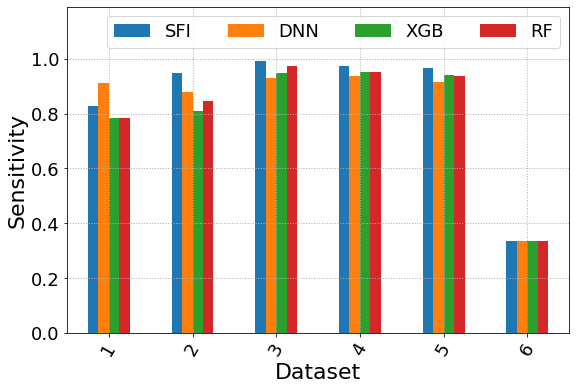

In [29]:
cls_plot(stat_cls, 'sens', 'Sensitivity')

### 5.2 Precision

<Figure size 864x648 with 0 Axes>

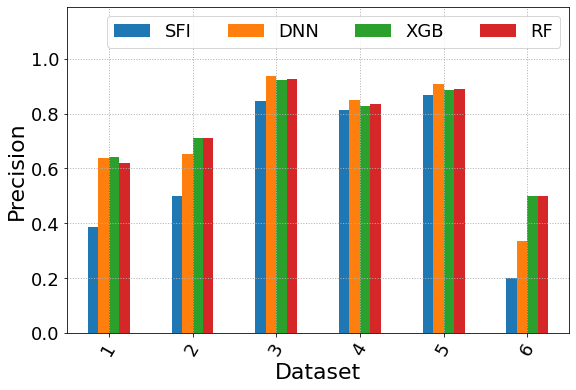

In [30]:
cls_plot(stat_cls, 'prec', 'Precision')

### 5.3 Specificity

<Figure size 864x648 with 0 Axes>

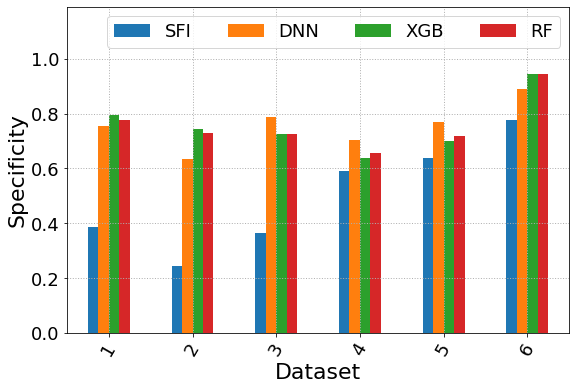

In [31]:
cls_plot(stat_cls, 'spec', 'Specificity')

### 5.4 Accuracy

<Figure size 864x648 with 0 Axes>

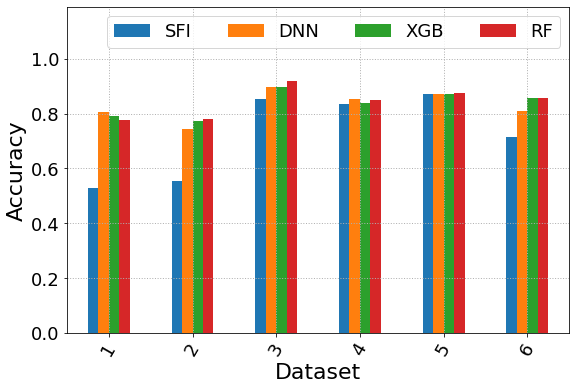

In [32]:
cls_plot(stat_cls, 'acc', 'Accuracy')

## 6 Analysis of all external validaiton sets in one
* Comparison between OpenSOL and SFI
* Mergeing six external validation sets in one and only keep compounds with clogP between -6 and 8. 

In [33]:
def sol_cols(sol):
    sol_list = []
    sol_len = len(sol)
    if sol_len == 1:
        sol_list.append('<{}'.format(sol[0]))
        sol_list.append('>{}'.format(sol[0]))

    else:
        for i, s in enumerate(range(sol_len)):
            if i == 0:
                sol_list.append('<{}'.format(sol[i]))
                sol_list.append('{} -> {}'.format(sol[i], sol[i + 1]))
            elif i == sol_len - 1:
                sol_list.append('>{}'.format(sol[i]))
            else:
                sol_list.append('{} -> {}'.format(sol[i], sol[i + 1]))
    return sol_list

In [34]:
def sol_cut(df_tmp, sol):
    sol_list = sol_cols(sol)
    df = pd.Series(0.0, index=sol_list)
    
    sol_len = len(sol)
    
    if sol_len == 1:
        df[sol_list[0]] = sum(df_tmp.logS_expr <= sol[0])
        df[sol_list[1]] = sum(df_tmp.logS_expr > sol[0])
    else:
        for i, s in enumerate(sol):
            if i == 0:
                df[sol_list[i]] = sum(df_tmp.logS_expr <= s)
                df[sol_list[i + 1]] = sum(df_tmp.logS_expr.between(sol[i], sol[i + 1]))
            elif i == sol_len - 1:
                df[sol_list[i + 1]] = sum(df_tmp.logS_expr > s)
            else:
                df[sol_list[i]] = sum(df_tmp.logS_expr.between(sol[i], sol[i + 1]))
    return df

In [35]:
# Code adapted from Dr. Patrick Walters's notebook: https://github.com/PatWalters/sfi/blob/main/example_sfi.ipynb

def get_fractions(vc):
    low = vc['Low']
    med = vc['Medium']
    hi = vc['High']
    total = low + med + hi
    if total > 0:
        res = [x/total for x in [low,med,hi]]
    else:
        res = [0,0,0]
    return res
    

def sfi_plot(df,sfi_column='SFI',logS_column="logS_expr", ranges=[0, 10], xlabel='SFI'):
    %matplotlib inline
    df['Label'] = pd.cut(df[logS_column],bins=[-100] + [np.log10(x*1e-06) for x in [30,200]] + [100],labels=["Low","Medium","High"])
    sfi_bins = [-100] + list(range(ranges[0],ranges[1])) + [100]
    sfi_labels = ['<{}'.format(ranges[0])] +[f"{x}->{x+1}" for x in range(ranges[0],ranges[1]-1)] + [">{}".format(ranges[1] - 1)]
    df['sfi_bin'] = pd.cut(df[sfi_column],bins=sfi_bins,labels=sfi_labels)
    res = []
    bin_counts = []
    for k,v in df.groupby('sfi_bin'):
        res.append([k]+get_fractions(v.Label.value_counts()))
        bin_counts.append(len(v))
    sfi_df = pd.DataFrame(res,columns=[sfi_column,"Poor","Inter","Good"])
    sns.set()
    sns.set(rc={'figure.figsize': (12, 9)})
    sns.set_style('white')
    sns.set_context('talk')
    ax = sfi_df.set_index(sfi_column).plot(kind="bar",stacked="True",color=['red','yellow','green'])
    ax.set_xlabel(xlabel, size=22)
    ax.set_ylabel('Frequency', size=22)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, size=20)
    ax.set_yticklabels([round(a, 1) for a in ax.get_yticks()], size=20)
    pos = -0.3
    for b in bin_counts:
        ax.text(pos,1.01,str(b).center(4))
        pos = pos+1.0
    #ax.legend(loc='upper center', bbox_to_anchor=(1.00, 0.75), ncol=3)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=3)
    fig = ax.get_figure()
    fig.savefig('../Test/graph/Categorical_plot_logS_expr_vs_{}.jpg'.format(xlabel), dpi=300)

In [36]:
df_list = []
cols = ['SMILES','logS_expr', 'SFI', 'rdkit_ClogP', 'random_forest_logS', 'dnn_logS', 'xgboost_logS']
for csv in csv_list:
    file_in = '{}/{}'.format(dirs_pred, csv)
    df_tmp = pd.read_csv(file_in)
    df_list.append(df_tmp[cols])
df_all = pd.concat(df_list, ignore_index=True)
df_all = df_all.loc[df_all.rdkit_ClogP.between(-6, 8)]
df_all.shape

(9664, 7)

In [37]:
SFI_range = [0, 10]
logP_range = [-4, 6]
logS_range = [-8, 2]

sol = [-4.52, -3.70]
#Red  <30µM
#Yellow 30-200µM
#Green >200µM

### 6.1.  SFI vs Experimental solubility (logS_expr)

C:\Users\xzhu\AppData\Local\Temp/ipykernel_849380/939890361.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(a, 1) for a in ax.get_yticks()], size=20)


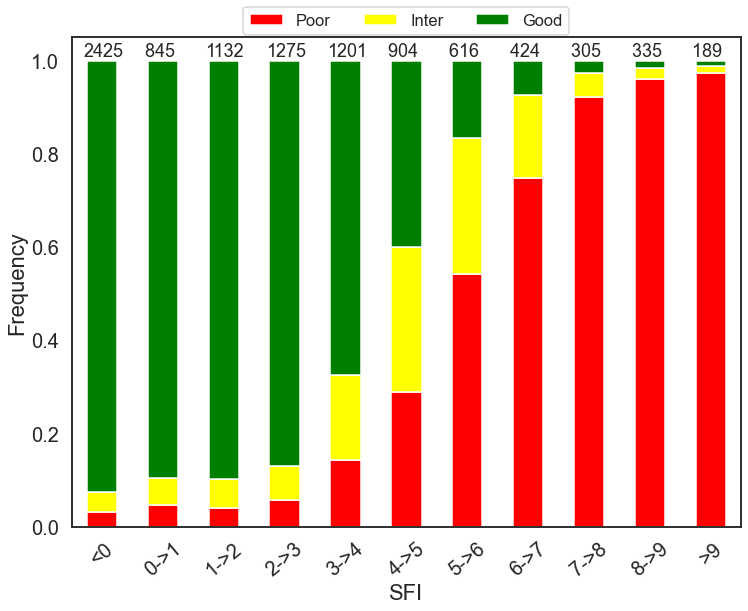

In [38]:
sfi_plot(df_all,sfi_column='SFI',logS_column="logS_expr", ranges=SFI_range)

### 6.2. XGB-GSE vs Experimental solublity

C:\Users\xzhu\AppData\Local\Temp/ipykernel_849380/939890361.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(a, 1) for a in ax.get_yticks()], size=20)


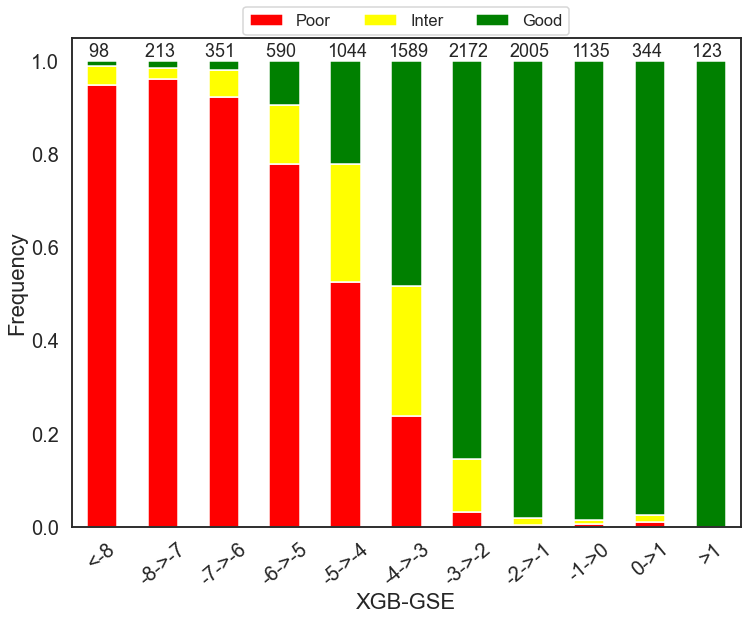

In [39]:
sfi_plot(df_all, sfi_column='xgboost_logS',logS_column="logS_expr", ranges=logS_range, xlabel='XGB-GSE')

### 6.3. RF-GSE vs Experimental solublity

C:\Users\xzhu\AppData\Local\Temp/ipykernel_849380/939890361.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(a, 1) for a in ax.get_yticks()], size=20)


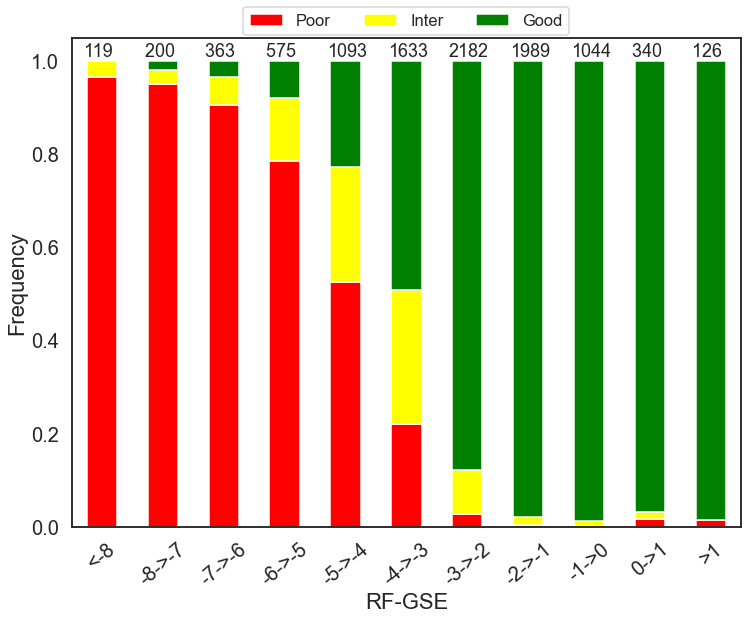

In [40]:
sfi_plot(df_all, sfi_column='random_forest_logS',logS_column="logS_expr", ranges=logS_range, xlabel='RF-GSE')

### 6.4. DNN-GSE vs Experimental solublity

C:\Users\xzhu\AppData\Local\Temp/ipykernel_849380/939890361.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(a, 1) for a in ax.get_yticks()], size=20)


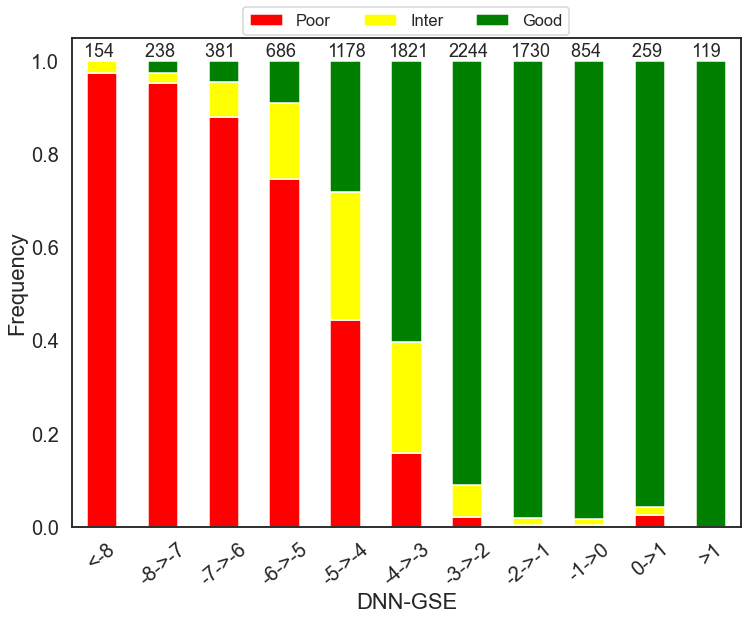

In [41]:
sfi_plot(df_all, sfi_column='dnn_logS',logS_column="logS_expr", ranges=logS_range, xlabel='DNN-GSE')

## 7. Physicochemical properties of validation sets

In [42]:
def prop(mol):
    # compute basic physicochemical properties
    MW, logP,  HBD, HBA, tPSA, RotB, SP3, ArRing = MolWt(mol), MolLogP(mol), NumHDonors(mol), NumHAcceptors(mol), TPSA(mol), CalcNumRotatableBonds(mol), CalcFractionCSP3(mol), CalcNumAromaticRings(mol)
    return MW, logP, HBD, HBA, tPSA, RotB, SP3, ArRing

In [43]:
def prop_calc(df, cols):
    try:
        PandasTools.AddMoleculeColumnToFrame(df, 'SMILES', 'molecule')
    except:
        print("Erroneous exception was raised and captured...")
    
    df[cols] = df.apply((lambda x: prop(x.molecule)), axis=1, result_type='expand')
    df.drop(labels='molecule', axis=1, inplace=True)
    return df

In [44]:
def hist_plot4test(df, col, legend, jpg_dir=False, bins=50, ylabel='Count', xlabel='MW', logY=False, xrange=False):
    %matplotlib inline
    font = {'family': 'normal', 'weight': 'normal', 'size': 12}
    matplotlib.rc('font', **font)
    fig = plt.figure(figsize=(9.0, 6.0), facecolor=(1, 1, 1))
    X = df[col].to_numpy()

    colors = ['b', 'brown']

    #plots the histogram
    fig, ax1 = plt.subplots()
    #ax1.set_yscale('log')
    #ax1.set_xscale('log')
    ax1.hist(X, bins=bins, color=colors[0], rwidth=0.7, label=legend)
    if xrange:
        ax1.set_xlim(xrange[0], xrange[1])

    plt.xticks(rotation=60)
    #plt.yticks(rotation=-15)
    ax1.set_ylabel(ylabel)
    ax1.set_xlabel(xlabel)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.grid(which='major', linestyle=':', linewidth=1)
    if jpg_dir:
        fig.savefig(jpg_dir, dpi=300)
    plt.show()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


<Figure size 648x432 with 0 Axes>

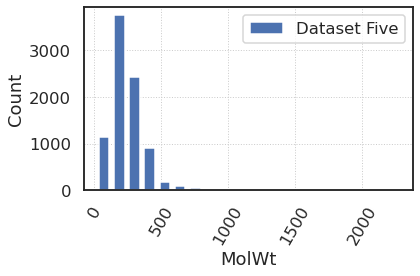

<Figure size 648x432 with 0 Axes>

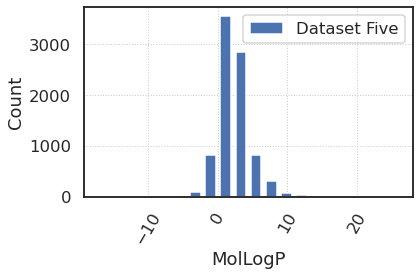

<Figure size 648x432 with 0 Axes>

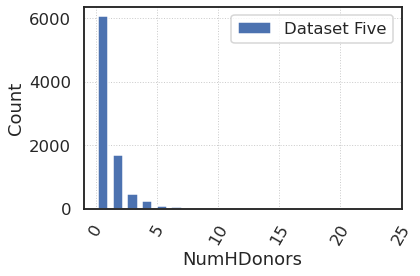

<Figure size 648x432 with 0 Axes>

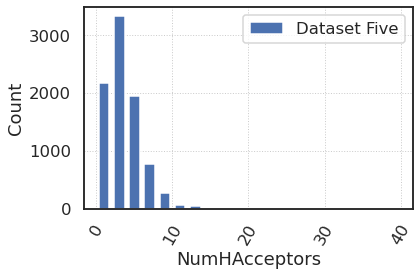

<Figure size 648x432 with 0 Axes>

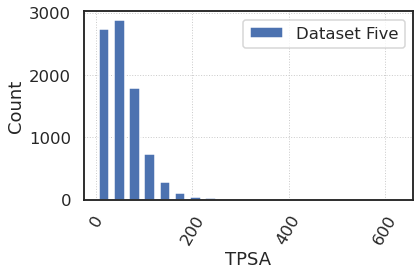

<Figure size 648x432 with 0 Axes>

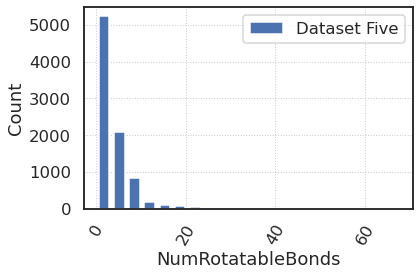

<Figure size 648x432 with 0 Axes>

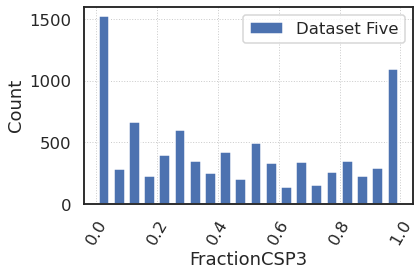

<Figure size 648x432 with 0 Axes>

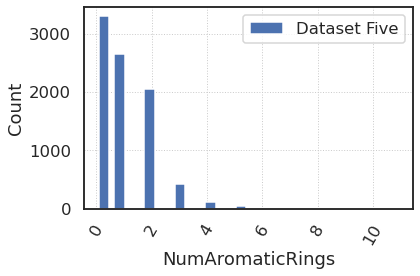

<Figure size 648x432 with 0 Axes>

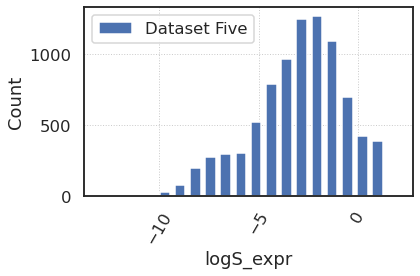

<Figure size 648x432 with 0 Axes>

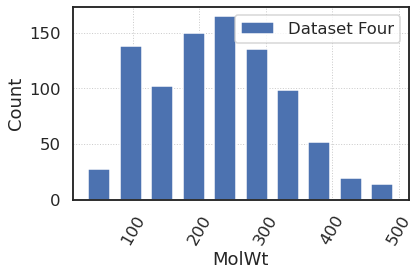

<Figure size 648x432 with 0 Axes>

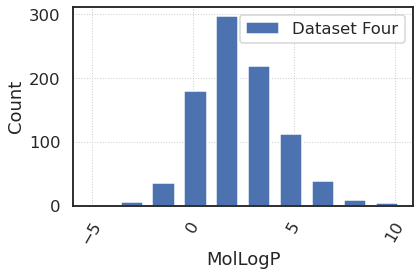

<Figure size 648x432 with 0 Axes>

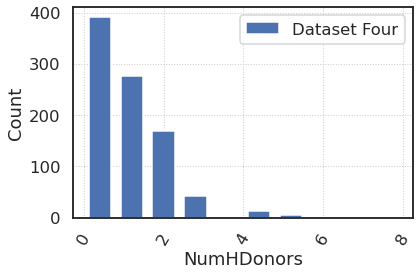

<Figure size 648x432 with 0 Axes>

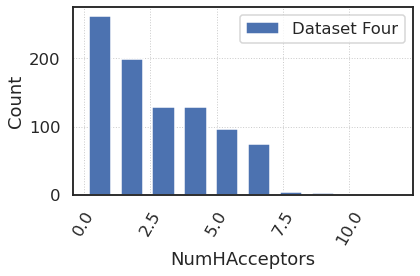

<Figure size 648x432 with 0 Axes>

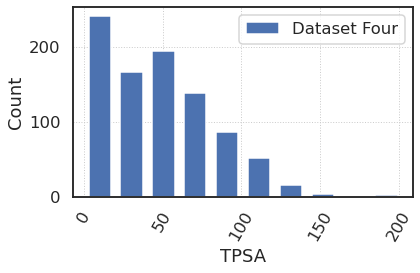

<Figure size 648x432 with 0 Axes>

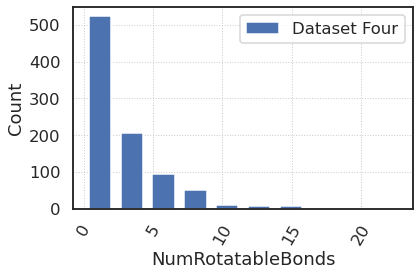

<Figure size 648x432 with 0 Axes>

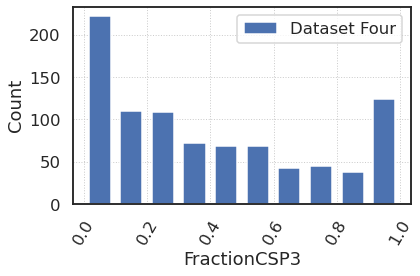

<Figure size 648x432 with 0 Axes>

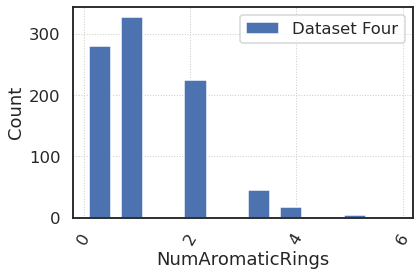

<Figure size 648x432 with 0 Axes>

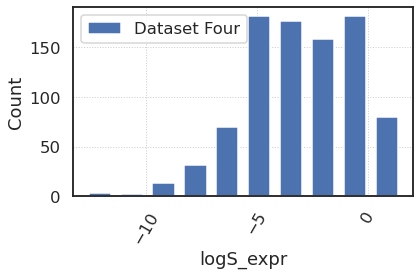

<Figure size 648x432 with 0 Axes>

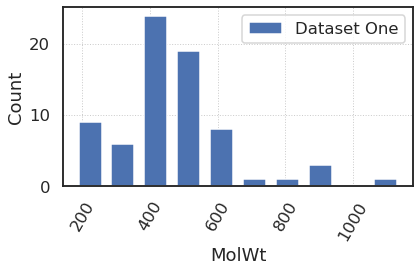

<Figure size 648x432 with 0 Axes>

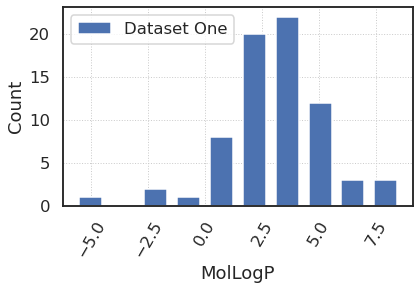

<Figure size 648x432 with 0 Axes>

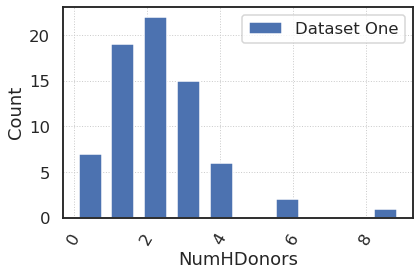

<Figure size 648x432 with 0 Axes>

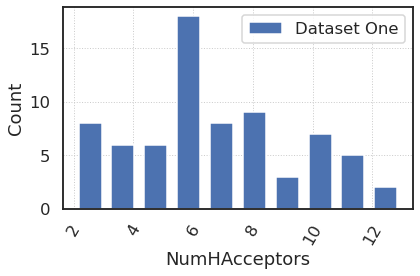

<Figure size 648x432 with 0 Axes>

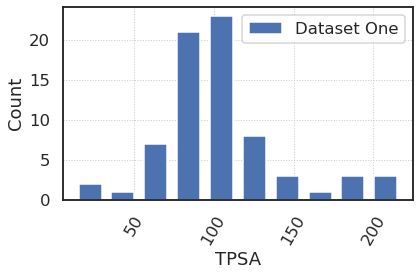

<Figure size 648x432 with 0 Axes>

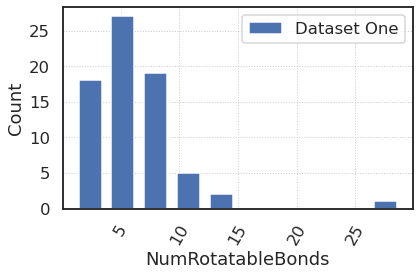

<Figure size 648x432 with 0 Axes>

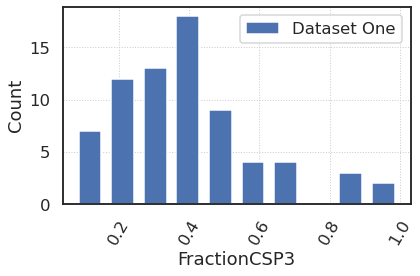

<Figure size 648x432 with 0 Axes>

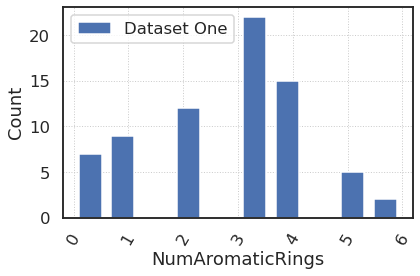

<Figure size 648x432 with 0 Axes>

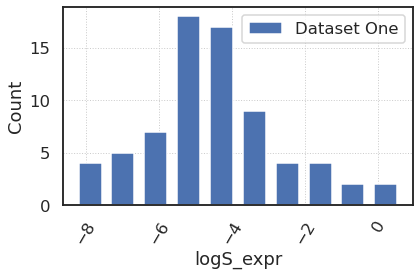

<Figure size 648x432 with 0 Axes>

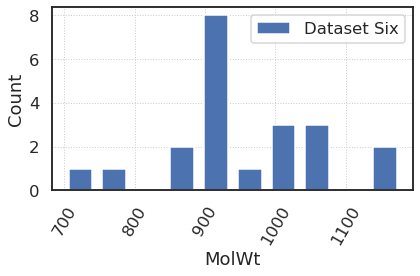

<Figure size 648x432 with 0 Axes>

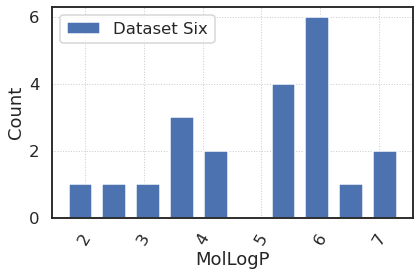

<Figure size 648x432 with 0 Axes>

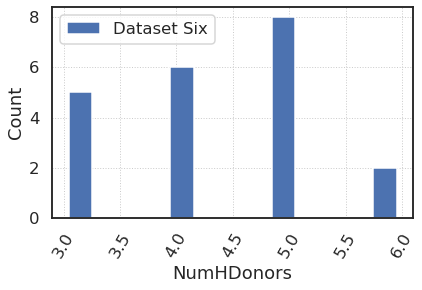

<Figure size 648x432 with 0 Axes>

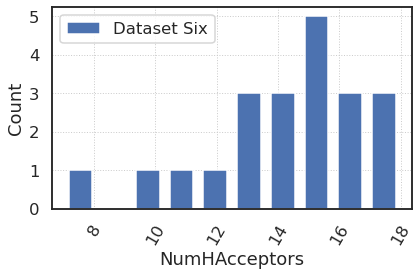

<Figure size 648x432 with 0 Axes>

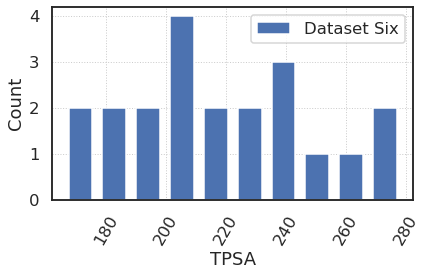

<Figure size 648x432 with 0 Axes>

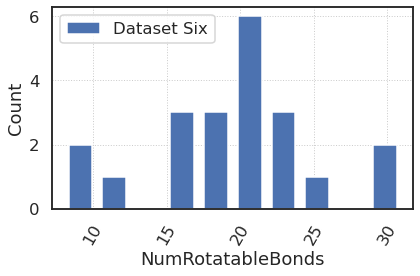

<Figure size 648x432 with 0 Axes>

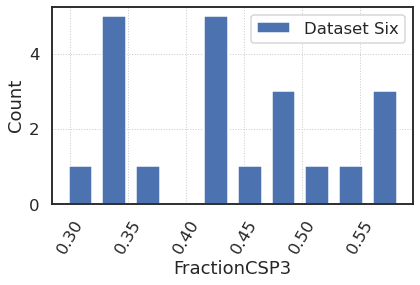

<Figure size 648x432 with 0 Axes>

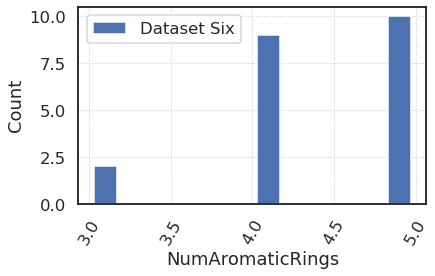

<Figure size 648x432 with 0 Axes>

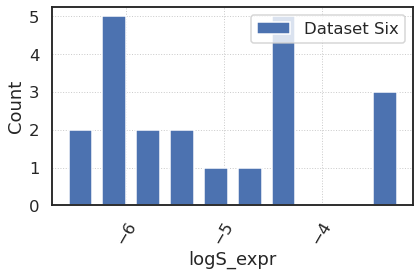

<Figure size 648x432 with 0 Axes>

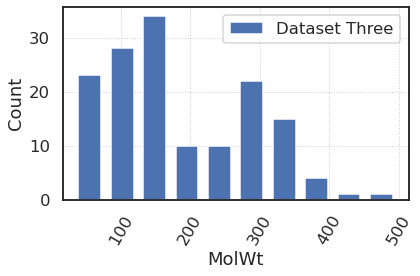

<Figure size 648x432 with 0 Axes>

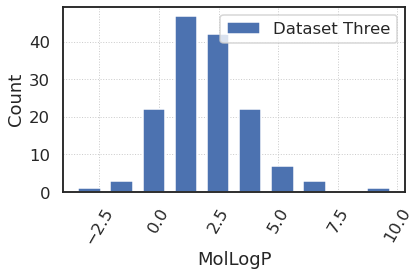

<Figure size 648x432 with 0 Axes>

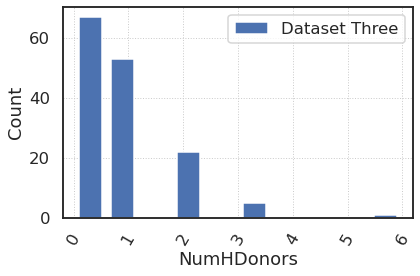

<Figure size 648x432 with 0 Axes>

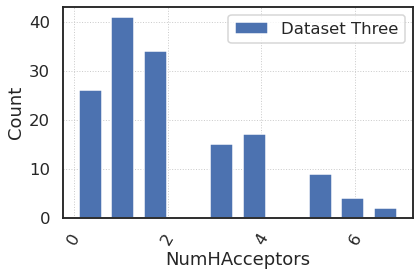

<Figure size 648x432 with 0 Axes>

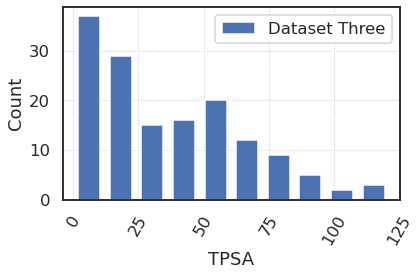

<Figure size 648x432 with 0 Axes>

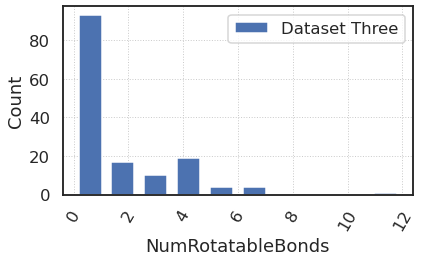

<Figure size 648x432 with 0 Axes>

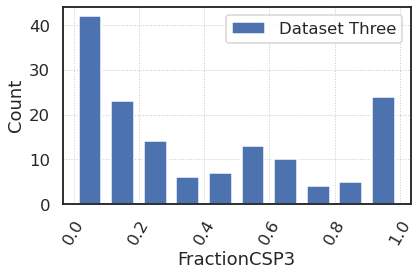

<Figure size 648x432 with 0 Axes>

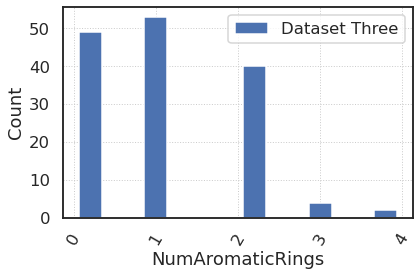

<Figure size 648x432 with 0 Axes>

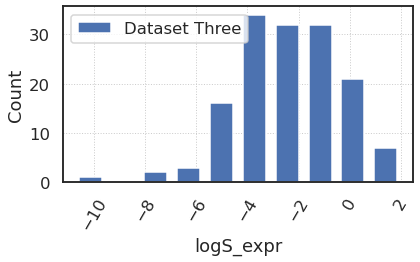

<Figure size 648x432 with 0 Axes>

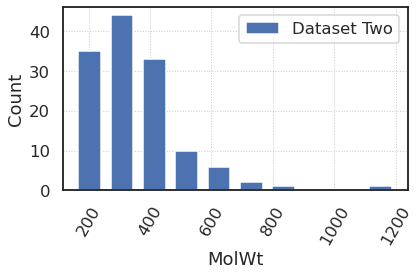

<Figure size 648x432 with 0 Axes>

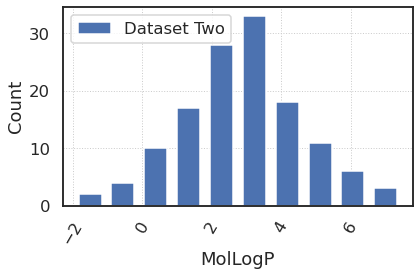

<Figure size 648x432 with 0 Axes>

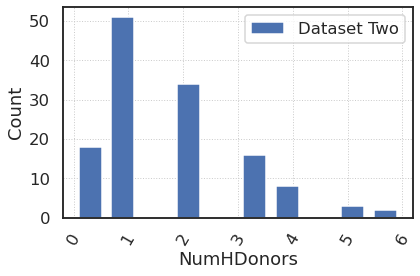

<Figure size 648x432 with 0 Axes>

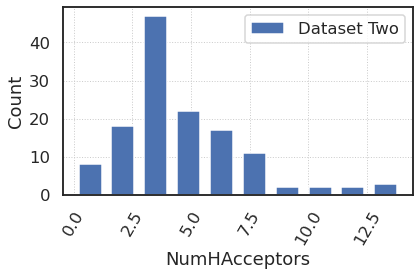

<Figure size 648x432 with 0 Axes>

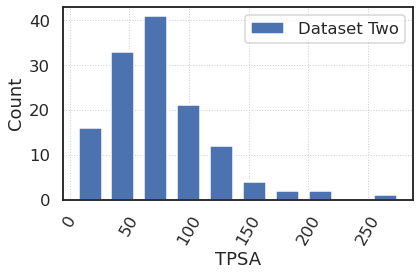

<Figure size 648x432 with 0 Axes>

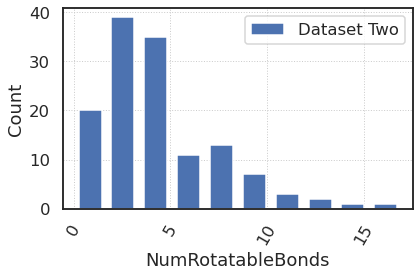

<Figure size 648x432 with 0 Axes>

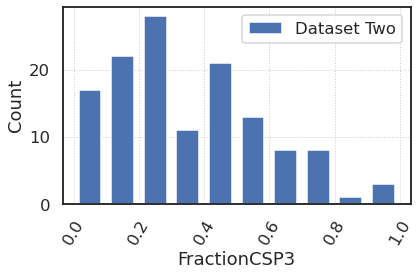

<Figure size 648x432 with 0 Axes>

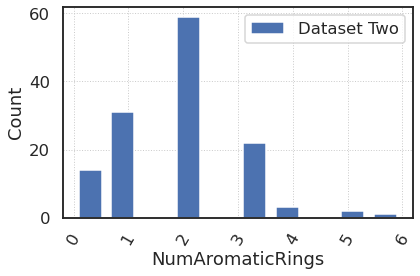

<Figure size 648x432 with 0 Axes>

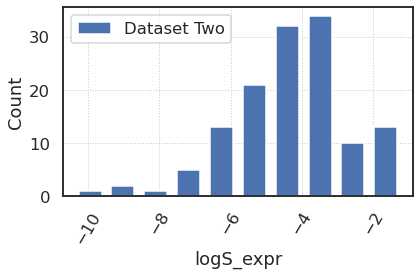

In [45]:
cols = ['MolWt', 'MolLogP', 'NumHDonors', 'NumHAcceptors', 'TPSA', 'NumRotatableBonds', 'FractionCSP3', 'NumAromaticRings']
#cols = ['MolWt', 'MolLogP', 'NumHDonors', 'NumHAcceptors', 'NumRotatableBonds']
col_names = cols + ['logS_expr']
for csv in csv_list:
    csv_file = '{}/{}'.format(dirs_pred, csv)
    df = pd.read_csv(csv_file, index_col=None)
    df = prop_calc(df, cols)
    csv_base = csv.split('_pred')[0]
    df_col_names = df[col_names]
    df_dscr = df.describe()
    #stat_save = '{}/{}_physcochem_stat.csv'.format(dirs_stat, csv_base)
    #df_dscr.to_csv(stat_save, index=True)
    
    if 'one' in csv_base:
        legend = 'Dataset One'
        bins = 10
    elif 'two' in csv_base:
        legend = 'Dataset Two'
        bins = 10
    elif 'three' in csv_base:
        legend = 'Dataset Three'
        bins = 10
    elif 'four' in csv_base:
        legend = 'Dataset Four'
        bins = 10
    elif 'five' in csv_base:
        legend = 'Dataset Five'
        bins = 20
    else:
        legend = 'Dataset Six'
        bins = 10
        
    for col in col_names:
        #jpg_dir = '{}/{}_{}.jpg'.format(dirs_stat, csv_base, col)
        #hist_plot4test(df, col, legend, jpg_dir=jpg_dir, bins=bins, ylabel='Count', xlabel=col, logY=False, xrange=False)
        hist_plot4test(df, col, legend, jpg_dir=False, bins=bins, ylabel='Count', xlabel=col, logY=False, xrange=False)